In [1]:
import torchaudio

waveform, sample_rate = torchaudio.load("assets/anime.wav")
print("original: \n", sample_rate)
print(waveform.shape)
audio_w = torchaudio.transforms.Resample(original_sr, TARGET_SR)(waveform)
audio_w, sr = audio_w, TARGET_SR
print("resampled: \n", sr)
print(audio_w.shape)

# so usually audio has 3 properties:
# 1. Channels
# 2. Sample rate
# 3. Time

# the lenght of the audio will be (time_measurements/sample_rate)
# so if we resample from
# original: 
#  16000
# torch.Size([1, 47104])
# resampled: 
#  24000
# torch.Size([1, 70656])

# the lenght of the audio still will be the same it's just (time_measurements/sample_rate) 

original: 
 16000
torch.Size([1, 47104])


/home/vladimir_albrekht/projects/img_to_spec/.venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/vladimir_albrekht/projects/img_to_spec/.venv/lib/python3.12/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see

NameError: name 'original_sr' is not defined

In [37]:
import math 
math.gcd(24000, 16000)


8000

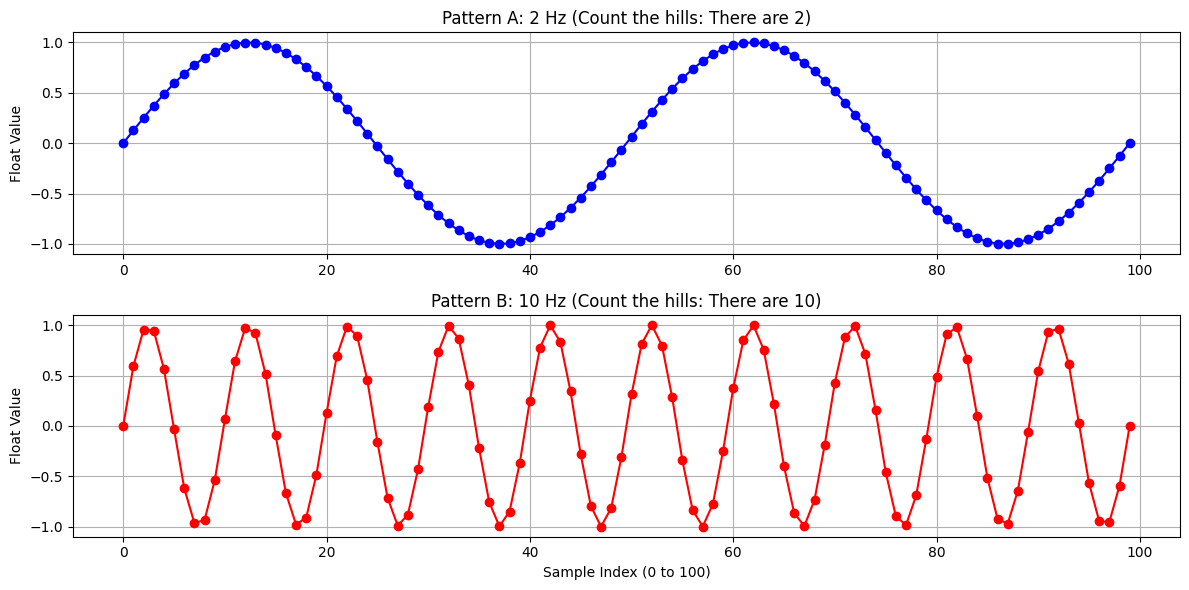

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup our "Time" ruler (1 Second long, 100 dots)
sample_rate = 100
time_points = np.linspace(0, 1, sample_rate)

# 2. Create Patterns (The Floats)
# Pattern A: 2 Cycles in 1 second
floats_A = np.sin(2 * np.pi * 2 * time_points)

# Pattern B: 10 Cycles in 1 second
floats_B = np.sin(2 * np.pi * 10 * time_points)

# 3. Visualize
plt.figure(figsize=(12, 6))

# Plot A
plt.subplot(2, 1, 1)
plt.plot(floats_A, marker='o', color='blue')
plt.title("Pattern A: 2 Hz (Count the hills: There are 2)")
plt.ylabel("Float Value")
plt.grid(True)

# Plot B
plt.subplot(2, 1, 2)
plt.plot(floats_B, marker='o', color='red')
plt.title("Pattern B: 10 Hz (Count the hills: There are 10)")
plt.ylabel("Float Value")
plt.xlabel("Sample Index (0 to 100)")
plt.grid(True)

plt.tight_layout()
plt.show()

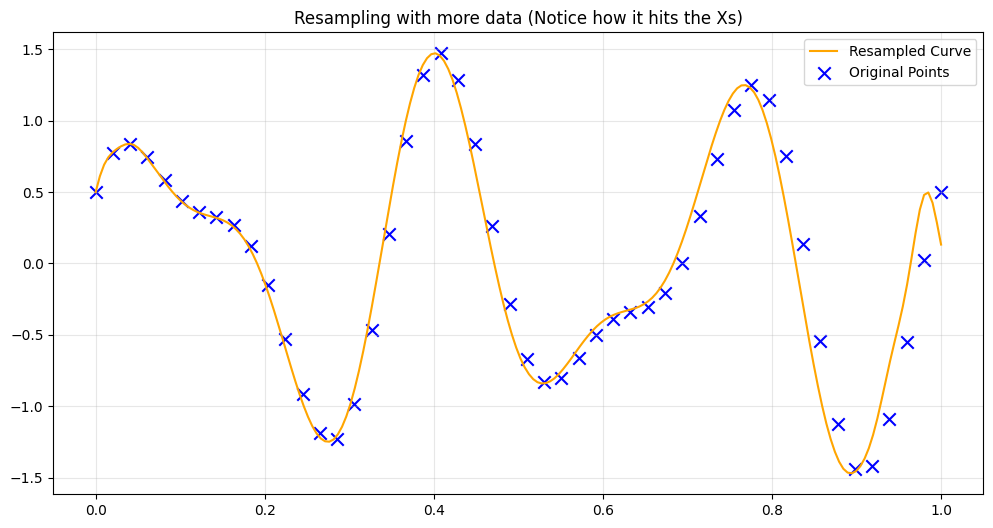

In [23]:
import torch
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# 1. Low Res (But enough data to avoid edge errors)
samples_low = 50 
t_low = torch.linspace(0, 1, samples_low)
# A complex wave
wave_low = (torch.sin(2 * np.pi * 3.0 * t_low) + 0.5 * torch.cos(2 * np.pi * 5.0 * t_low)).unsqueeze(0)

# 2. Resample to High Res
samples_high = 200 # 4x upsample
resampler = T.Resample(orig_freq=samples_low, new_freq=samples_high)
wave_high = resampler(wave_low)

# 3. VISUALIZE
plt.figure(figsize=(12, 6))

# High Res Line
plt.plot(np.linspace(0, 1, samples_high), wave_high.squeeze().numpy(), 
         color='orange', label='Resampled Curve')

# Low Res Dots
plt.scatter(np.linspace(0, 1, samples_low), wave_low.squeeze().numpy(), 
            color='blue', marker='x', s=80, label='Original Points')

plt.title("Resampling with more data (Notice how it hits the Xs)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# MEL

## Basic inference of MEL with vocos

Loading Vocos...
Prepared Waveform: torch.Size([1, 72000])
Mel Spectrogram:   torch.Size([1, 100, 282])
 - Height (Freq):  100
 - Width (Time):   282

--- 1. ORIGINAL (Padded to 3s) ---



--- 2. RECONSTRUCTED FROM MEL ---


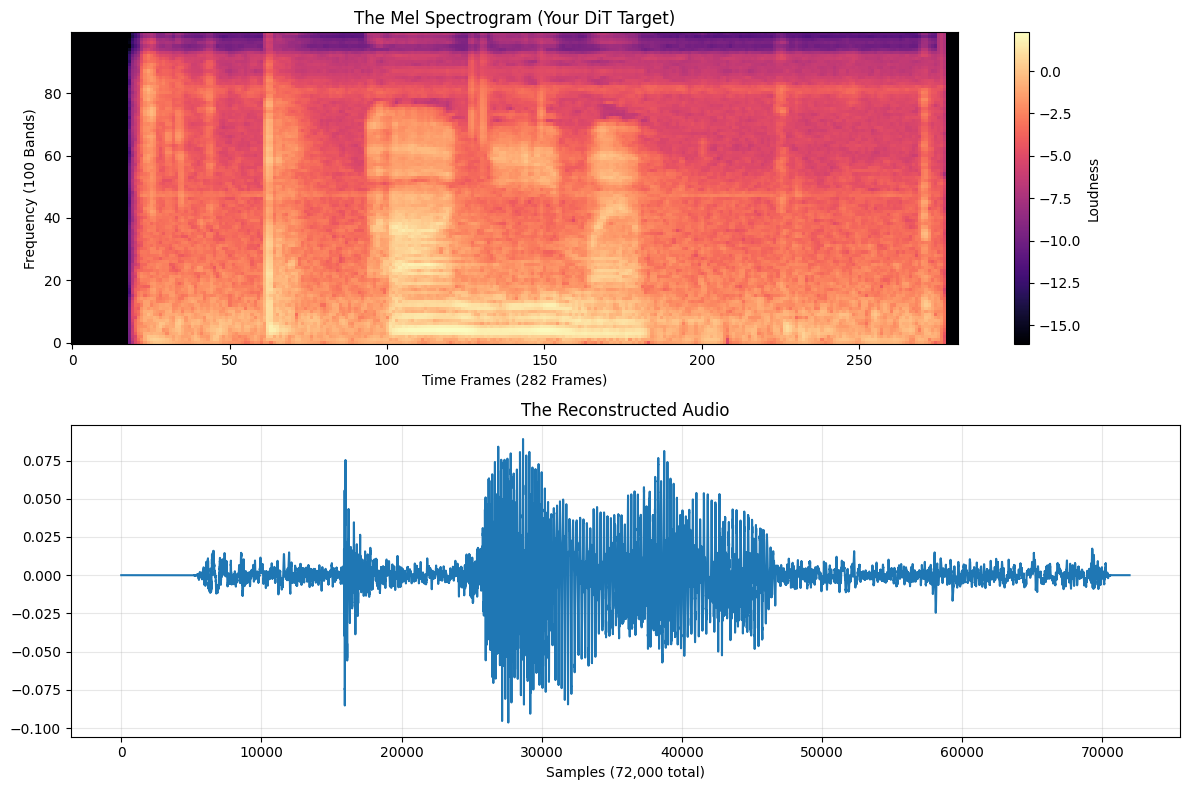

In [2]:
import torch
import torchaudio
import torch.nn.functional as F
from vocos import Vocos
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# ==========================================
# 1. CONFIGURATION
# ==========================================
class AudioConfig:
    audio_path = "assets/anime.wav"
    target_sr = 24000          # Vocos requires 24kHz
    target_duration = 3.0      # We want fixed 3-second chunks
    
    # Calculated samples: 24000 * 3 = 72000
    target_samples = int(target_sr * target_duration) 

config = AudioConfig()

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================
def load_and_prep_audio(path, target_sr, target_samples):
    """
    Loads, Resamples, and Pads/Crops audio to a fixed length.
    """
    # 1. Load
    waveform, sr = torchaudio.load(path)
    
    # 2. Force Mono
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
        
    # 3. Resample (16k -> 24k)
    if sr != target_sr:
        resampler = torchaudio.transforms.Resample(sr, target_sr)
        waveform = resampler(waveform)
        
    # 4. Pad or Crop to exactly 72000 samples
    current_length = waveform.shape[-1]
    
    if current_length < target_samples:
        # Pad with silence (zeros) at the end
        padding = target_samples - current_length
        waveform = F.pad(waveform, (0, padding))
    elif current_length > target_samples:
        # Crop the end
        waveform = waveform[:, :target_samples]
        
    return waveform

# ==========================================
# 3. MAIN EXECUTION
# ==========================================

# A. Load Model
print("Loading Vocos...")
vocos = Vocos.from_pretrained("charactr/vocos-mel-24khz")
vocos.eval()

# B. Prepare Audio (The Input)
# Input: Audio File -> Output: Tensor [1, 72000]
waveform = load_and_prep_audio(
    config.audio_path, 
    config.target_sr, 
    config.target_samples
)
print(f"Prepared Waveform: {waveform.shape}")

# C. Generate Mel Spectrogram (The Target)
# Input: [1, 72000] -> Output: [1, 100, 282]
with torch.no_grad():
    mel_spec = vocos.feature_extractor(waveform)

print(f"Mel Spectrogram:   {mel_spec.shape}")
print(f" - Height (Freq):  {mel_spec.shape[1]}")
print(f" - Width (Time):   {mel_spec.shape[2]}")

# D. Reconstruct (Verification)
with torch.no_grad():
    reconstructed = vocos.decode(mel_spec)

# ==========================================
# 4. VISUALIZATION
# ==========================================
print("\n--- 1. ORIGINAL (Padded to 3s) ---")
display(Audio(waveform.numpy(), rate=config.target_sr))

print("\n--- 2. RECONSTRUCTED FROM MEL ---")
display(Audio(reconstructed.numpy(), rate=config.target_sr))

plt.figure(figsize=(12, 8))

# Plot 1: The Mel Spectrogram (What the DiT sees)
plt.subplot(2, 1, 1)
plt.imshow(mel_spec[0].numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title("The Mel Spectrogram (Your DiT Target)")
plt.ylabel(f"Frequency ({mel_spec.shape[1]} Bands)")
plt.xlabel(f"Time Frames ({mel_spec.shape[2]} Frames)")
plt.colorbar(label="Loudness")

# Plot 2: The Waveform (What the Speaker plays)
plt.subplot(2, 1, 2)
plt.plot(reconstructed[0].numpy())
plt.title("The Reconstructed Audio")
plt.xlabel("Samples (72,000 total)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

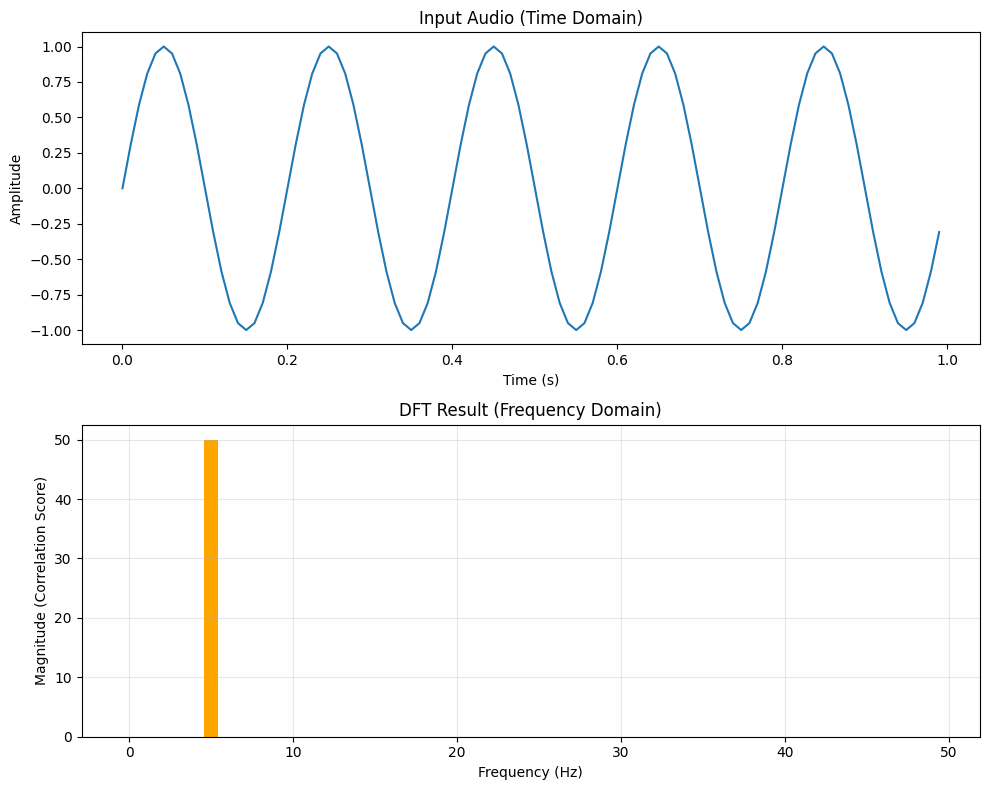

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. CREATE A SIGNAL (The Smoothie)
# ==========================================
# Let's mix a Bass note (5 Hz) and a Treble note (50 Hz)
duration = 1.0
sr = 100
t = np.linspace(0, duration, int(sr * duration), endpoint=False)

# The "Hidden" Recipe we want to find:
signal = 1.0 * np.sin(2 * np.pi * 5 * t) + 0.5 * np.sin(2 * np.pi * 50 * t)

# ==========================================
# 2. THE DFT ALGORITHM (Manual)
# ==========================================
def calculate_dft_magnitude(signal, sr):
    N = len(signal)
    magnitudes = []
    frequencies = []
    
    # Check every possible frequency from 0 to Nyquist (SR/2)
    # This is the "Filter Bank" logic
    for freq_to_check in range(0, sr // 2):
        
        # A. Create the "Probe" (The Sine Wave to compare against)
        # In real math, we use e^(-i...), which combines Sin and Cos.
        # Here, we simplify to just Sin/Cos for visual intuition.
        probe_wave = np.exp(-2j * np.pi * freq_to_check * np.arange(N) / N)
        
        # B. The Dot Product (Similarity Check)
        # Multiply Audio * Probe and Sum it up
        dot_product = np.sum(signal * probe_wave)
        
        # C. Calculate Magnitude (Energy)
        # We take absolute value to handle complex numbers
        magnitude = np.abs(dot_product)
        
        magnitudes.append(magnitude)
        frequencies.append(freq_to_check)
        
    return frequencies, magnitudes

# Run it
freqs, mags = calculate_dft_magnitude(signal, sr)

# ==========================================
# 3. VISUALIZE
# ==========================================
plt.figure(figsize=(10, 8))

# Plot 1: The Input (Time Domain)
plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.title("Input Audio (Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Plot 2: The Output (Frequency Domain)
plt.subplot(2, 1, 2)
plt.bar(freqs, mags, color='orange')
plt.title("DFT Result (Frequency Domain)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (Correlation Score)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
85 / (1024/24000)

1992.1875

In [34]:
import torch

x = torch.randn(2)

y = torch.randn(2, 2)


print(x)
print(y)

print(x @ y)


tensor([-0.6713, -0.7845])
tensor([[ 0.0231,  0.8759],
        [ 0.5535, -0.9234]])
tensor([-0.4497,  0.1364])


In [18]:
5 * 24000 / 1024

117.1875

In [ ]:
import torch
x = torch.randn(1024)
y = torch.randn(1024)

print(x @ y)

tensor(-21.4769)


In [ ]:
import math

# 1. THE CONVERTER (Your Formula)
def hz_to_mel(freq):
    return 2595 * math.log10(1 + freq / 700)

# 2. THE REVERSE CONVERTER (Algebra to undo step 1)
def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)

# --- THE PROCESS ---

# A. Get the Boundaries
start_hz = 0
end_hz = 12000

start_mel = hz_to_mel(start_hz)
end_mel = hz_to_mel(end_hz)

print(f"Start Mel: t{start_mel:.2f}")
print(f"End Mel:   {end_mel:.2f}")

# B. Calculate the Step Size (The Slice)
num_buckets = 100
mel_step_size = (end_mel - start_mel) / num_buckets

print(f"Step Size: {mel_step_size:.2f} Mel (This is 3257 / 100)")

# C. Find Bucket #1 Center (In Mel)
# We take 1 step from the start
bucket_1_mel = start_mel + (1 * mel_step_size)
print(f"Bucket 1 Center (Mel): {bucket_1_mel:.2f}")

# D. Convert that Center back to Hz
bucket_1_hz = mel_to_hz(bucket_1_mel)
print(f"Bucket 1 Center (Hz):  {bucket_1_hz:.2f} Hz")

# Let's try a high bucket (Bucket #90)
bucket_90_mel = start_mel + (90 * mel_step_size)
bucket_90_hz = mel_to_hz(bucket_90_mel)
print(f"Bucket 90 Center (Hz): {bucket_90_hz:.2f} Hz")

Start Mel: 0.00
End Mel:   3266.34
Step Size: 32.66 Mel (This is 3257 / 100)
Bucket 1 Center (Mel): 32.66
Bucket 1 Center (Hz):  20.58 Hz
Bucket 90 Center (Hz): 8804.58 Hz


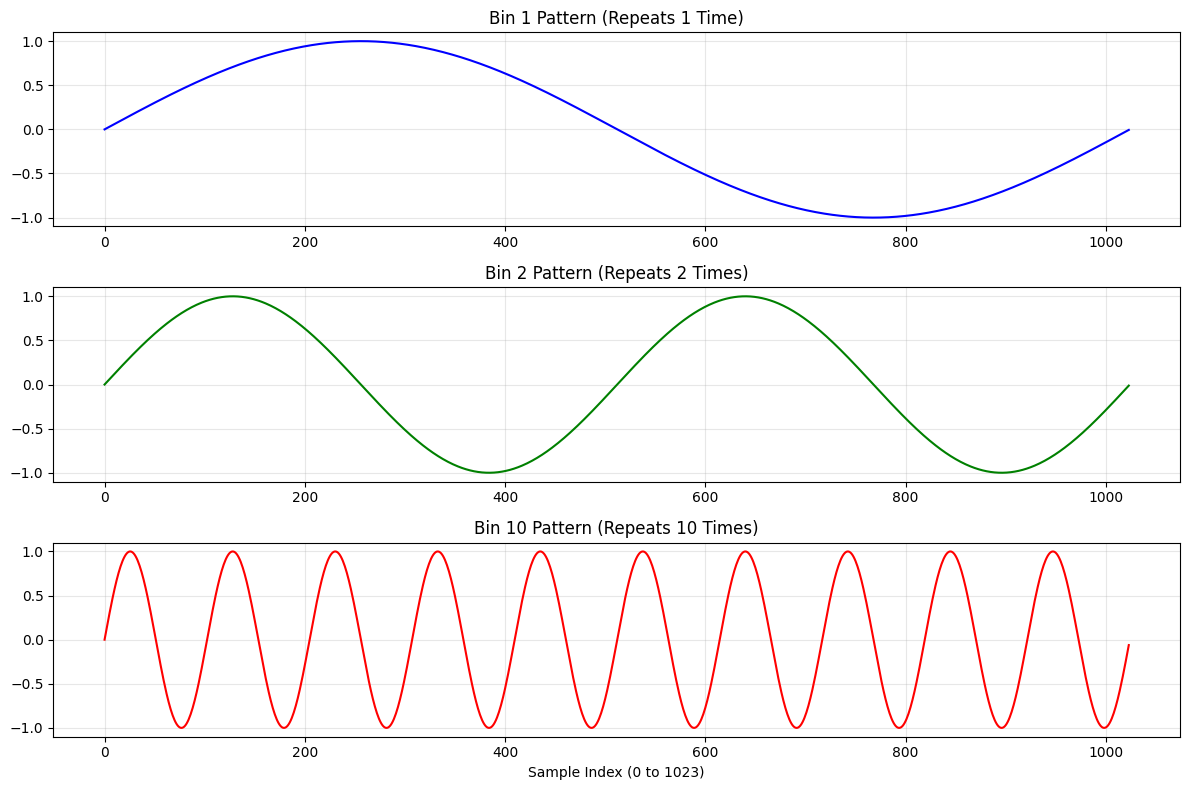

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 1. SETUP
window_size = 1024
x = np.arange(window_size)

# 2. GENERATE THE PATTERNS (The "Probes")
# Bin 1: 1 Cycle
probe_1 = np.sin(2 * np.pi * 1 * x / window_size)

# Bin 2: 2 Cycles
probe_2 = np.sin(2 * np.pi * 2 * x / window_size)

# Bin 10: 10 Cycles
probe_10 = np.sin(2 * np.pi * 10 * x / window_size)

# 3. VISUALIZE
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(probe_1, color='blue')
plt.title("Bin 1 Pattern (Repeats 1 Time)")
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(probe_2, color='green')
plt.title("Bin 2 Pattern (Repeats 2 Times)")
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(probe_10, color='red')
plt.title("Bin 10 Pattern (Repeats 10 Times)")
plt.xlabel("Sample Index (0 to 1023)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [3]:
def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)
print(mel_to_hz(32.66))

20.58261804639685


/home/vladimir_albrekht/projects/img_to_spec/.venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/vladimir_albrekht/projects/img_to_spec/.venv/lib/python3.12/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see

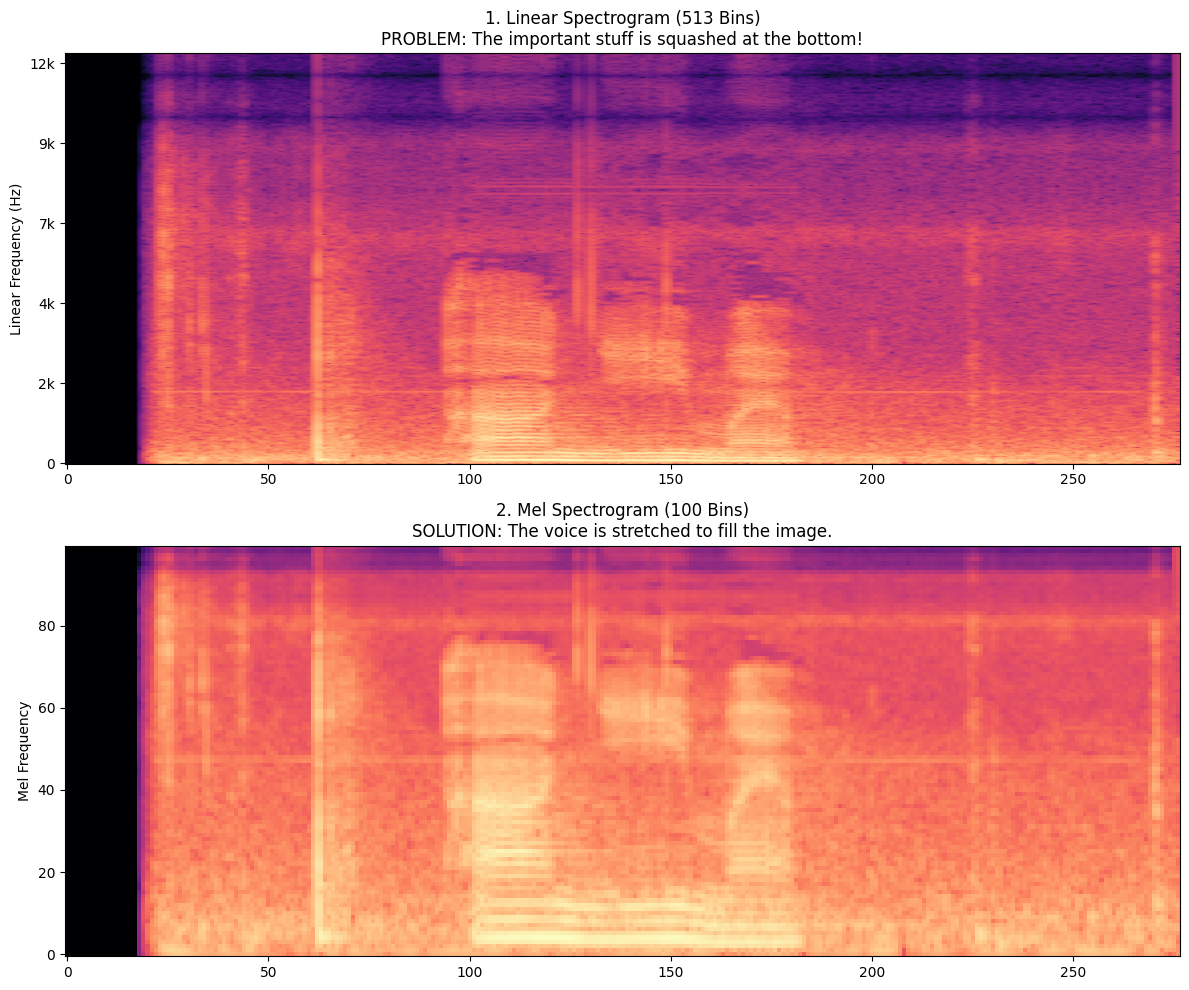

In [4]:
import torch
import torchaudio.transforms as T
import torchaudio
import matplotlib.pyplot as plt

# Load Audio
waveform, sr = torchaudio.load("assets/anime.wav")
# Resample to 24k for standard view
waveform = T.Resample(sr, 24000)(waveform)

# ==========================================
# 1. LINEAR SPECTROGRAM (The Physics Output)
# ==========================================
# This is what you get if you STOP after the FFT (513 bins)
linear_transform = T.Spectrogram(
    n_fft=1024,
    hop_length=256,
    power=1.0,
    normalized=True
)
linear_spec = torch.log(linear_transform(waveform) + 1e-9)

# ==========================================
# 2. MEL SPECTROGRAM (The Biology Output)
# ==========================================
# This is what you get after the Matrix Multiplication (100 bins)
mel_transform = T.MelSpectrogram(
    sample_rate=24000,
    n_fft=1024,
    n_mels=100,
    hop_length=256,
    power=1.0,
    normalized=True,
    norm=None,
    mel_scale="htk"
)
mel_spec = torch.log(mel_transform(waveform) + 1e-9)

# ==========================================
# 3. VISUALIZE THE PROBLEM
# ==========================================
plt.figure(figsize=(12, 10))

# Plot Linear
plt.subplot(2, 1, 1)
plt.imshow(linear_spec[0].numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title(f"1. Linear Spectrogram ({linear_spec.shape[1]} Bins)\nPROBLEM: The important stuff is squashed at the bottom!")
plt.ylabel("Linear Frequency (Hz)")
plt.yticks([0, 100, 200, 300, 400, 500], ['0', '2k', '4k', '7k', '9k', '12k'])

# Plot Mel
plt.subplot(2, 1, 2)
plt.imshow(mel_spec[0].numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title(f"2. Mel Spectrogram ({mel_spec.shape[1]} Bins)\nSOLUTION: The voice is stretched to fill the image.")
plt.ylabel("Mel Frequency")

plt.tight_layout()
plt.show()

In [ ]:
import torch

x = torch.randn(2)
print(x)

y = torch.randn(2, 10)
print(y)

print(x @ y)
# = -0.869 - 0.2736

tensor([-1.0164,  1.0555])
tensor([[ 0.8555,  1.9701,  0.5032,  0.6043, -1.4673, -0.5099,  0.4564, -0.9523,
         -1.7574,  1.3138],
        [-0.2593, -0.2801,  0.6512,  0.3178, -1.4618, -1.1327,  0.1264, -1.4603,
          0.9173,  1.3253]])
tensor([-1.1431, -2.2980,  0.1759, -0.2788, -0.0516, -0.6773, -0.3304, -0.5735,
         2.7543,  0.0635])


In [11]:
print(-0.869 - 0.2736)

-1.1426


Matrix Shape (y.T): torch.Size([513, 100])


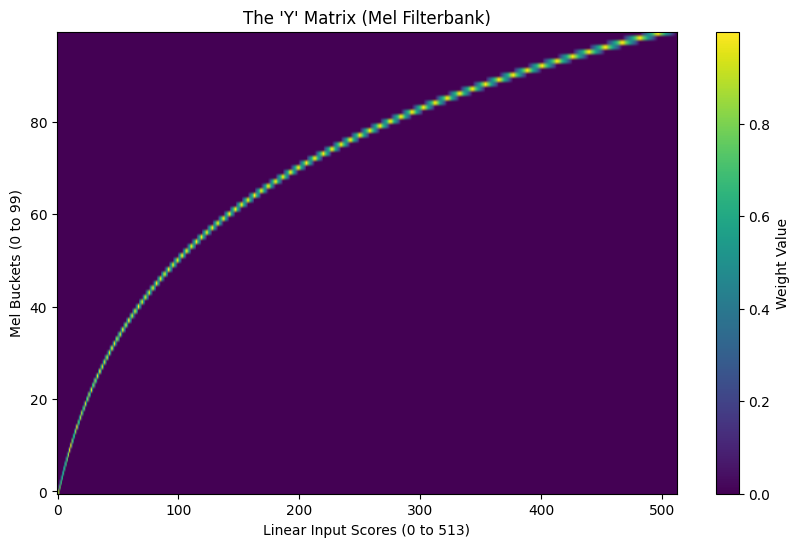


--- Look at Row 50 (Mid Range) ---
Most values are zero. It only cares about a specific range:
tensor([0.1270, 0.4009, 0.6748, 0.9487, 0.7836, 0.5175, 0.2513])


In [13]:
import torch
import torchaudio.functional as F
import matplotlib.pyplot as plt

# Config matching Vocos
n_fft = 1024
n_mels = 100
sample_rate = 24000

# THIS GENERATES 'Y'
# It's not random. It's a calculated filter bank.
mel_matrix = F.melscale_fbanks(
    n_freqs=(n_fft // 2) + 1,  # 513 Input columns
    f_min=0,
    f_max=sample_rate / 2,
    n_mels=n_mels,             # 100 Output rows
    sample_rate=sample_rate,
    norm=None,
    mel_scale="htk"
)

print(f"Matrix Shape (y.T): {mel_matrix.shape}") 
# [513, 100] -> PyTorch creates it transposed by default for easy multiplication

# ==========================================
# VISUALIZE Y (NOT RANDOM!)
# ==========================================
plt.figure(figsize=(10, 6))
plt.imshow(mel_matrix.numpy().T, aspect='auto', origin='lower', cmap='viridis')
plt.title("The 'Y' Matrix (Mel Filterbank)")
plt.ylabel("Mel Buckets (0 to 99)")
plt.xlabel("Linear Input Scores (0 to 513)")
plt.colorbar(label="Weight Value")
plt.show()

# Let's inspect ONE row (Bucket #50)
row_50 = mel_matrix.T[50]
print("\n--- Look at Row 50 (Mid Range) ---")
print("Most values are zero. It only cares about a specific range:")
# Show only non-zero values
non_zeros = row_50[row_50 > 0]
print(non_zeros)

In [5]:
import math
import torchaudio.functional as F

# 1. THE FORMULA (Your Code)
def hz_to_mel(freq):
    return 2595 * math.log10(1 + freq / 700)

def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)

# 2. CALCULATE LIMITS
max_hz = 12000
max_mel = hz_to_mel(max_hz)

print(f"12,000 Hz is equal to {max_mel:.2f} Mels")

# 3. PROVE THE DISTORTION
# Let's look at the width of Bucket #1 vs Bucket #99
# Total Mel Range divided by 100 buckets
step_mel = max_mel / 100

# Bucket 1 (Bass)
mel_start = 0
mel_end = step_mel
hz_width_bass = mel_to_hz(mel_end) - mel_to_hz(mel_start)

# Bucket 99 (Treble)
mel_start_high = max_mel - step_mel
mel_end_high = max_mel
hz_width_treble = mel_to_hz(mel_end_high) - mel_to_hz(mel_start_high)

print("\n--- THE DISTORTION ---")
print(f"In Mel World, every bucket is {step_mel:.2f} wide.")
print(f"In Hz World (Physics):")
print(f"  - Bass Bucket Width:   {hz_width_bass:.2f} Hz  (Tiny!)")
print(f"  - Treble Bucket Width: {hz_width_treble:.2f} Hz (Huge!)")

12,000 Hz is equal to 3266.34 Mels

--- THE DISTORTION ---
In Mel World, every bucket is 32.66 wide.
In Hz World (Physics):
  - Bass Bucket Width:   20.58 Hz  (Tiny!)
  - Treble Bucket Width: 362.80 Hz (Huge!)


## FFT from scratch (Fast Fourier Transform)

Loading Vocos...
Input Waveform: torch.Size([1, 70656])
Target Mel Shape: torch.Size([1, 100, 277])
My Mel Shape:     torch.Size([1, 100, 277])


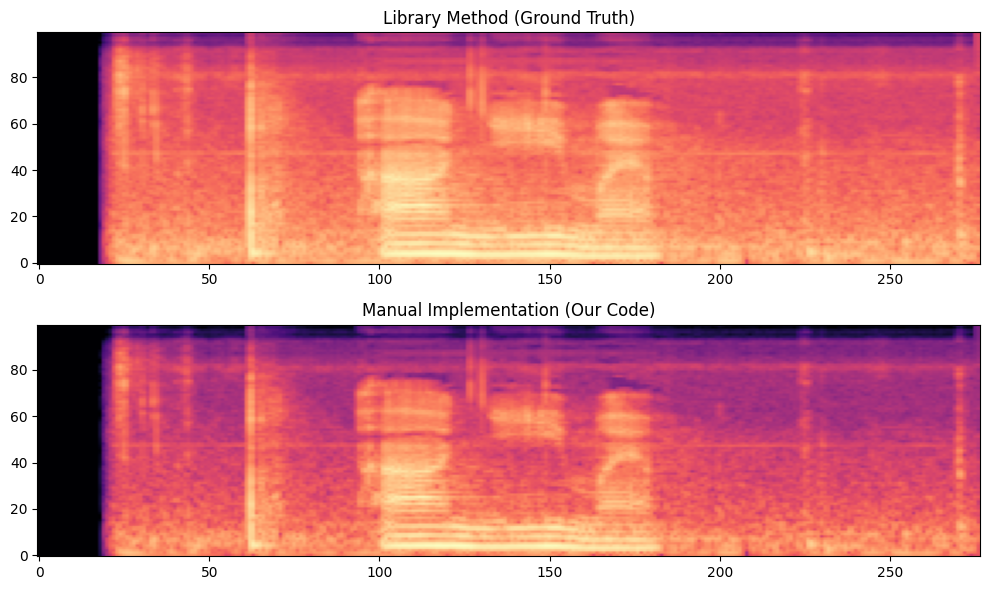


Average Difference (Error): 0.302699
❌ FAIL. The math is different.

Decoding YOUR manual mel...


In [ ]:
import torch
import torchaudio
import torchaudio.functional as F
from vocos import Vocos
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# ==========================================
# 1. SETUP & LOAD GROUND TRUTH
# ==========================================
TARGET_SR = 24000
audio_path = "assets/anime.wav"

# Load Library Model
print("Loading Vocos...")
vocos = Vocos.from_pretrained("charactr/vocos-mel-24khz")
vocos.eval()

# Prepare Audio
waveform, sr = torchaudio.load(audio_path)
if waveform.shape[0] > 1: waveform = waveform.mean(dim=0, keepdim=True)
if sr != TARGET_SR: waveform = torchaudio.transforms.Resample(sr, TARGET_SR)(waveform)

# Pad to safe length for testing
if waveform.shape[-1] < 24000:
    waveform = torch.nn.functional.pad(waveform, (0, 24000 - waveform.shape[-1]))

print(f"Input Waveform: {waveform.shape}")

# ==========================================
# 2. RUN LIBRARY METHOD (The Target)
# ==========================================
with torch.no_grad():
    # This is what we want to replicate
    target_mel = vocos.feature_extractor(waveform)

print(f"Target Mel Shape: {target_mel.shape}")

# ==========================================
# 3. MANUAL IMPLEMENTATION (The Challenge)
# ==========================================
# We will not use 'vocos.feature_extractor'.
# We will build it from raw parts.

def manual_feature_extractor(audio_wave):
    # --- CONFIG (Must match Vocos config) ---
    n_fft = 1024
    hop_length = 256
    win_length = 1024
    n_mels = 100
    sample_rate = 24000
    f_min = 0
    f_max = float(sample_rate / 2)
    
    # STEP A: THE PHYSICS (STFT)
    # This is the FFT part. It converts Time -> Linear Frequency.
    # We use center=True to match how most libs handle padding.
    window = torch.hann_window(win_length).to(audio_wave.device)
    
    stft_complex = torch.stft(
        audio_wave.squeeze(),
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
        center=True,
        pad_mode="reflect",
        normalized=False,
        onesided=True,
        return_complex=True
    )
    
    # Convert Complex Numbers to Magnitude (Absolute value)
    # This gives us the [513, Time] Linear Spectrogram
    linear_spec = torch.abs(stft_complex)
    
    # STEP B: THE BIOLOGY (Mel Matrix)
    # Create the transformation matrix [513, 100]
    mel_basis = F.melscale_fbanks(
        n_freqs=(n_fft // 2) + 1, # 513
        f_min=f_min,
        f_max=f_max,
        n_mels=n_mels,
        sample_rate=sample_rate,
        norm=None,       # Vocos uses Slaney norm
        mel_scale="htk"   # Vocos uses Slaney scale
    ).to(audio_wave.device)
    
    # Perform Matrix Multiplication
    # [513, Time] * [513, 100] -> [100, Time]
    # We transpose linear_spec to make shapes align for matmul, then transpose back
    mel_spec = torch.matmul(linear_spec.transpose(0, 1), mel_basis).transpose(0, 1)
    
    # STEP C: LOG COMPRESSION
    # Turn raw energy into Decibels (Log Scale)
    log_mel_spec = torch.log(torch.clamp(mel_spec, min=1e-5))
    
    return log_mel_spec.unsqueeze(0) # Add batch dim back

# Run our manual code
my_mel = manual_feature_extractor(waveform)

print(f"My Mel Shape:     {my_mel.shape}")

# ==========================================
# 4. COMPARE & DECODE
# ==========================================

# A. Visual Comparison
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.imshow(target_mel[0].numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title("Library Method (Ground Truth)")
plt.subplot(2, 1, 2)
plt.imshow(my_mel[0].numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title("Manual Implementation (Our Code)")
plt.tight_layout()
plt.show()

# B. Check Error (Difference)
diff = torch.mean(torch.abs(target_mel - my_mel))
print(f"\nAverage Difference (Error): {diff:.6f}")
if diff < 0.1:
    print("✅ SUCCESS! Your manual code matches the library!")
else:
    print("❌ FAIL. The math is different.")

# C. Decode using Library Decoder
# We pass OUR manually created mel into the Library's decoder
print("\nDecoding YOUR manual mel...")
with torch.no_grad():
    reconstructed = vocos.decode(my_mel)

display(Audio(reconstructed.numpy(), rate=TARGET_SR))

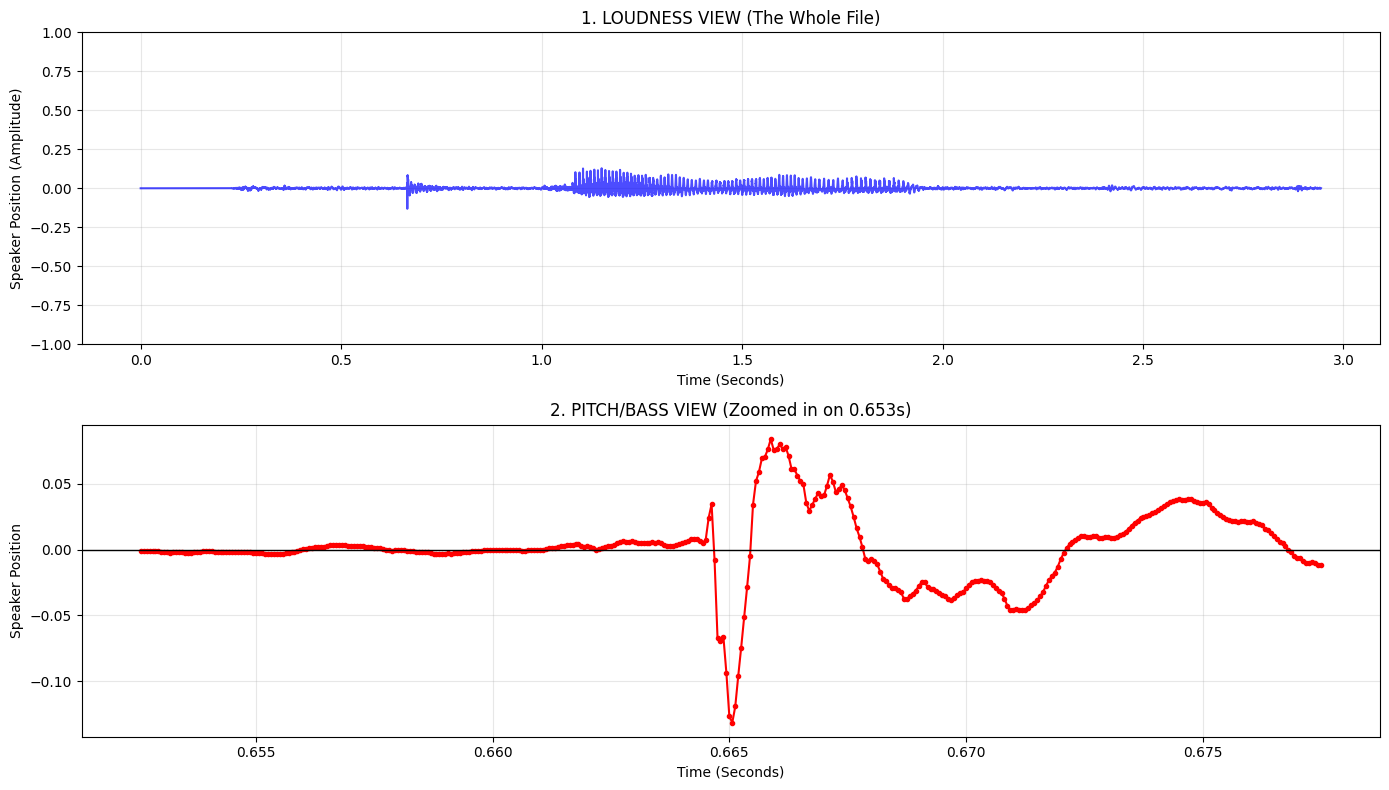

In [17]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

# Load your specific file
audio_path = "assets/anime.wav"
waveform, sr = torchaudio.load(audio_path)

# Convert to Mono for easier viewing
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)

# Convert to simple list of numbers
data = waveform.squeeze().numpy()
time_axis = np.arange(len(data)) / sr

plt.figure(figsize=(14, 8))

# ==========================================
# GRAPH 1: LOUDNESS (The Whole Story)
# ==========================================
plt.subplot(2, 1, 1)
plt.plot(time_axis, data, color='blue', alpha=0.7)
plt.title("1. LOUDNESS VIEW (The Whole File)")
plt.ylabel("Speaker Position (Amplitude)")
plt.xlabel("Time (Seconds)")
plt.ylim(-1, 1) # Fixed range to see true volume
plt.grid(True, alpha=0.3)

# ==========================================
# GRAPH 2: PITCH/BASS (The Microscope)
# ==========================================
# We zoom into a specific split-second where there is sound
# Let's find the loudest point and zoom in there
center = np.argmax(np.abs(data))
start = center - 200 # 200 samples to the left
end = center + 200   # 200 samples to the right

zoom_data = data[start:end]
zoom_time = time_axis[start:end]

plt.subplot(2, 1, 2)
plt.plot(zoom_time, zoom_data, color='red', marker='o', markersize=3)
plt.title(f"2. PITCH/BASS VIEW (Zoomed in on {zoom_time[0]:.3f}s)")
plt.ylabel("Speaker Position")
plt.xlabel("Time (Seconds)")
plt.grid(True, alpha=0.3)

# Draw lines to show how we read pitch
plt.axhline(0, color='black', linewidth=1)

plt.tight_layout()
plt.show()

Loading Vocos Feature Extractor...
INPUT: Raw Waveform | Shape: torch.Size([1, 72000])
OUTPUT: Mel Spectrogram | Shape: torch.Size([1, 100, 282])

--- Analyzing Time Frame #50 ---
This column represents approx 0.01 seconds of audio.
It contains 100 numbers (The 100 Frequency Bands).
Min Value (Silence): -10.7579
Max Value (Loudness): -0.1291


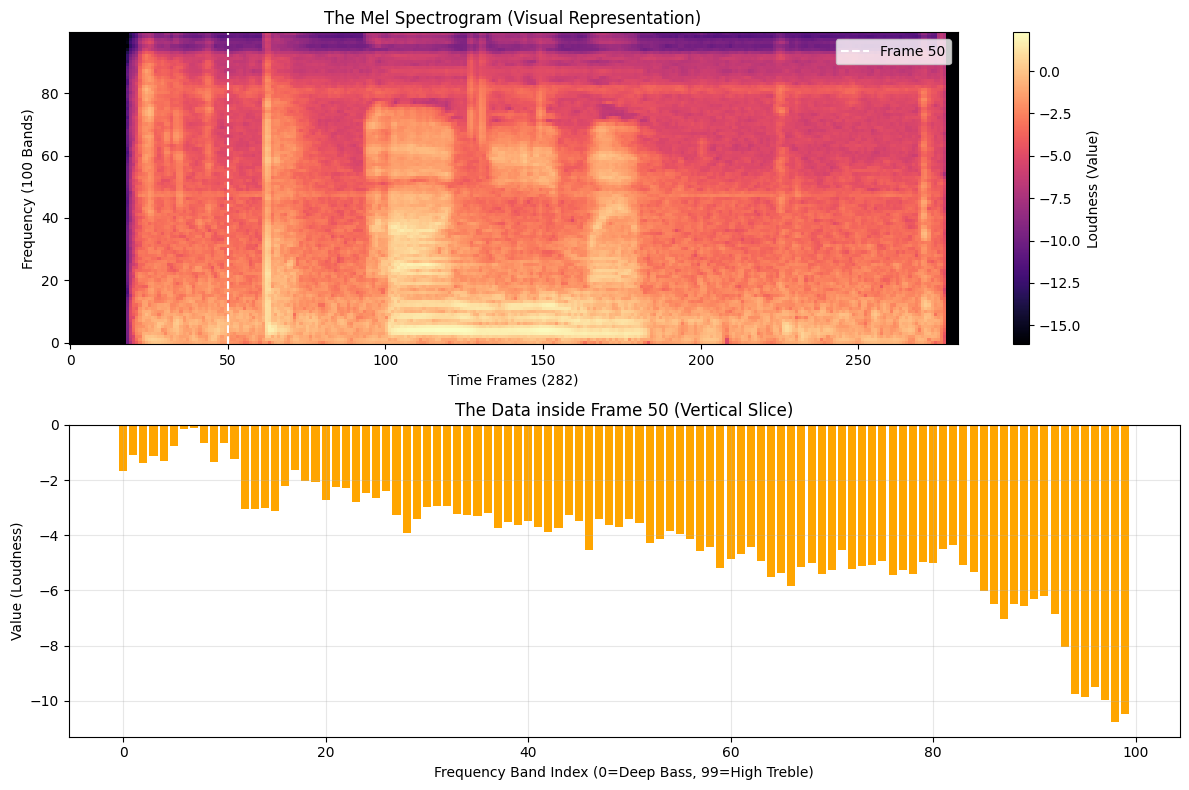

In [ ]:
import torch
import torchaudio
import torch.nn.functional as F
from vocos import Vocos
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. SETUP
# ==========================================
TARGET_SR = 24000
TARGET_SECONDS = 3.0 
TARGET_SAMPLES = int(TARGET_SR * TARGET_SECONDS) # 72,000

audio_path = "assets/anime.wav"

print("Loading Vocos Feature Extractor...")
vocos = Vocos.from_pretrained("charactr/vocos-mel-24khz")
vocos.eval()

# ==========================================
# 2. PREPARE RAW AUDIO (Input)
# ==========================================
waveform, original_sr = torchaudio.load(audio_path)

# Mono & Resample
if waveform.shape[0] > 1: waveform = waveform.mean(dim=0, keepdim=True)
if original_sr != TARGET_SR:
    waveform = torchaudio.transforms.Resample(original_sr, TARGET_SR)(waveform)

# Pad to exactly 72,000 samples
if waveform.shape[-1] < TARGET_SAMPLES:
    missing = TARGET_SAMPLES - waveform.shape[-1]
    waveform = F.pad(waveform, (0, missing))
elif waveform.shape[-1] > TARGET_SAMPLES:
    waveform = waveform[:, :TARGET_SAMPLES]

print(f"INPUT: Raw Waveform | Shape: {waveform.shape}")
# [1, 72000] -> [1 Channel, 72000 Air Pressure Measurements]

# ==========================================
# 3. GENERATE MEL SPECTROGRAM (Output)
# ==========================================
# This function does the Math: STFT -> Magnitude -> Mel Scale
with torch.no_grad():
    mel_spec = vocos.feature_extractor(waveform)

print(f"OUTPUT: Mel Spectrogram | Shape: {mel_spec.shape}")
# Expect: [1, 100, 282]

# ==========================================
# 4. DEEP DIVE: UNDERSTANDING THE DATA
# ==========================================

# Let's look at ONE specific column (Time Frame #50)
time_frame_index = 50
one_column = mel_spec[0, :, time_frame_index]

print(f"\n--- Analyzing Time Frame #{time_frame_index} ---")
print(f"This column represents approx 0.01 seconds of audio.")
print(f"It contains {len(one_column)} numbers (The 100 Frequency Bands).")
print(f"Min Value (Silence): {one_column.min():.4f}")
print(f"Max Value (Loudness): {one_column.max():.4f}")

# Visualize
plt.figure(figsize=(12, 8))

# Plot 1: The Image (The Spectrogram)
plt.subplot(2, 1, 1)
plt.imshow(mel_spec[0].numpy(), aspect='auto', origin='lower', cmap='magma')
plt.axvline(x=time_frame_index, color='white', linestyle='--', label=f'Frame {time_frame_index}')
plt.title("The Mel Spectrogram (Visual Representation)")
plt.ylabel("Frequency (100 Bands)")
plt.xlabel("Time Frames (282)")
plt.colorbar(label="Loudness (Value)")
plt.legend()

# Plot 2: The "Slice" (What the computer sees at Frame 50)
plt.subplot(2, 1, 2)
plt.bar(range(100), one_column.numpy(), color='orange')
plt.title(f"The Data inside Frame {time_frame_index} (Vertical Slice)")
plt.xlabel("Frequency Band Index (0=Deep Bass, 99=High Treble)")
plt.ylabel("Value (Loudness)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print("Hello World")

Loading Vocos...
Original Loaded: torch.Size([1, 47104]) @ 16000 Hz
Ready for Vocos: torch.Size([1, 47104]) @ 16000 Hz
Mel Spectrogram Shape: torch.Size([1, 100, 185])

--- ORIGINAL (Resampled to 24k) ---



--- VOCOS RECONSTRUCTED ---


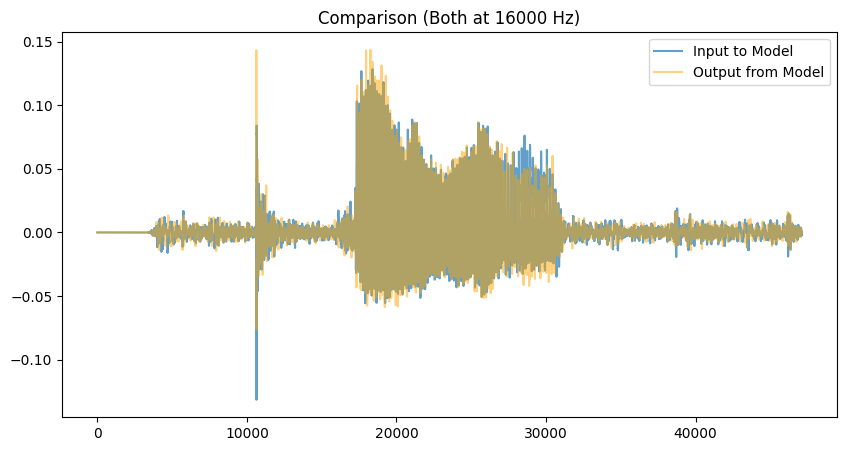

In [7]:
import torch
import torchaudio
from vocos import Vocos
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# ==========================================
# 1. SETUP
# ==========================================
# !!! IMPORTANT !!! 
# Even though your file is 16k, we MUST set this to 24000 
# because the Vocoder Model demands 24000.
TARGET_SR = 16000 

audio_path = "assets/anime.wav"

# Load Vocos
print("Loading Vocos...")
vocos = Vocos.from_pretrained("charactr/vocos-mel-24khz")
vocos.eval()

# ==========================================
# 2. LOAD & RESAMPLE (The Conversion)
# ==========================================
# A. Load the original file (PyTorch sees it is 16000 Hz)
waveform, original_sr = torchaudio.load(audio_path)

print(f"Original Loaded: {waveform.shape} @ {original_sr} Hz")

# B. Force Mono
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)

# C. THE UPSAMPLING STEP
# If the file is 16000, and Target is 24000, this if-statement runs.
if original_sr != TARGET_SR:
    print(f"⚠️ Resampling from {original_sr} Hz to {TARGET_SR} Hz...")
    
    # This mathematical transform fills in the missing data points
    resampler = torchaudio.transforms.Resample(orig_freq=original_sr, new_freq=TARGET_SR)
    waveform = resampler(waveform)

print(f"Ready for Vocos: {waveform.shape} @ {TARGET_SR} Hz")

# ==========================================
# 3. GENERATE TARGET (MEL)
# ==========================================
with torch.no_grad():
    mel_spec = vocos.feature_extractor(waveform)

print(f"Mel Spectrogram Shape: {mel_spec.shape}")

# ==========================================
# 4. RECONSTRUCT
# ==========================================
with torch.no_grad():
    reconstructed_audio = vocos.decode(mel_spec)

# ==========================================
# 5. LISTEN & VERIFY
# ==========================================
print("\n--- ORIGINAL (Resampled to 24k) ---")
# We play it at 24k because we upsampled it
display(Audio(waveform.numpy(), rate=TARGET_SR))

print("\n--- VOCOS RECONSTRUCTED ---")
display(Audio(reconstructed_audio.numpy(), rate=TARGET_SR))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(waveform[0].numpy(), label="Input to Model", alpha=0.7)
plt.plot(reconstructed_audio[0].numpy(), label="Output from Model", alpha=0.5, color='orange')
plt.title(f"Comparison (Both at {TARGET_SR} Hz)")
plt.legend()
plt.show()

In [5]:
import torch
import torchaudio

# Load the file
waveform, sample_rate = torchaudio.load("assets/anime.wav")

# Print the first 10 numbers
print("--- The First 10 Values ---")
print(waveform[0, :10])

# Let's find a loud moment (not silence)
loud_index = waveform.abs().argmax() # Find the biggest number
print("\n--- A Loud Moment ---")
print(waveform[0, loud_index : loud_index+5])

--- The First 10 Values ---
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

--- A Loud Moment ---
tensor([-0.1315, -0.1193, -0.0963, -0.0745, -0.0516])


In [18]:
import torch
import torchaudio
from IPython.display import Audio

# 1. Load Original (24k)
waveform, sr = torchaudio.load("assets/anime.wav") 
# waveform is [1, 15390], sr is 24000

print("1. Playing Normal...")
display(Audio(waveform.numpy(), rate=14000))

print("2. Playing at 8k (Your Idea)...")
# We pass the SAME waveform, but tell the player "rate=8000"
display(Audio(waveform.numpy(), rate=8000)) 
# Result: It will be long and deep.

print("3. Playing at 48k (Fast Forward)...")
# We pass the SAME waveform, but tell the player "rate=48000"
display(Audio(waveform.numpy(), rate=18000))
# Result: It will be super fast and high pitched (Chipmunk voice).

1. Playing Normal...


2. Playing at 8k (Your Idea)...


3. Playing at 48k (Fast Forward)...


--- FILE INFO ---
Sample Rate: 22050 Hz (Measurements per second)
Shape:       torch.Size([1, 15930]) -> [Channels, Time]
Data Type:   torch.float32

--- RAW DATA (First 10 samples) ---
tensor([-9.1553e-05,  0.0000e+00,  0.0000e+00, -9.1553e-05,  0.0000e+00,
        -6.1035e-05,  3.0518e-05, -3.0518e-05,  0.0000e+00,  0.0000e+00])

Max Volume: 1.0000
Min Volume: -0.5179

Duration: 0.72 seconds


/home/vladimir_albrekht/projects/img_to_spec/.venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/vladimir_albrekht/projects/img_to_spec/.venv/lib/python3.12/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see

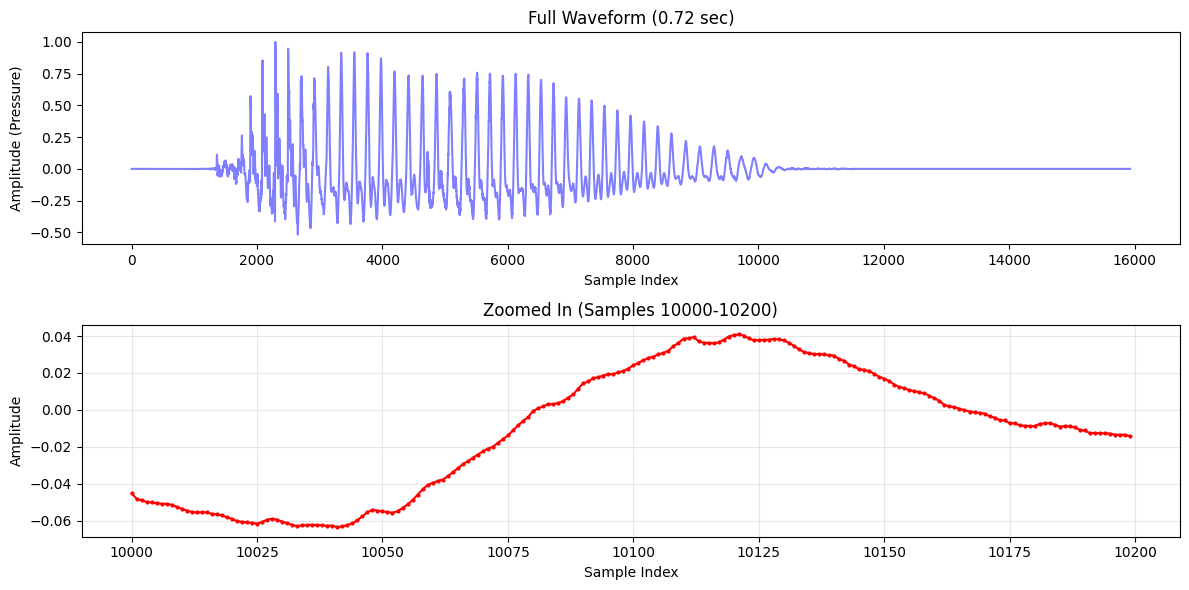

In [6]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Audio
audio_path = "assets/anime.wav"
# normalize=True creates floats between -1 and 1 (Standard)
waveform, sample_rate = torchaudio.load(audio_path, normalize=True)

print("--- FILE INFO ---")
print(f"Sample Rate: {sample_rate} Hz (Measurements per second)")
print(f"Shape:       {waveform.shape} -> [Channels, Time]")
print(f"Data Type:   {waveform.dtype}")

# 2. Analyze the Numbers
# Let's look at the first 10 numbers (The first 0.0004 seconds)
print("\n--- RAW DATA (First 10 samples) ---")
print(waveform[0, :10])

# Let's find the loudest moment
max_val = waveform.max()
min_val = waveform.min()
print(f"\nMax Volume: {max_val:.4f}")
print(f"Min Volume: {min_val:.4f}")

# 3. Calculate Duration
num_samples = waveform.shape[1]
duration_seconds = num_samples / sample_rate
print(f"\nDuration: {duration_seconds:.2f} seconds")

# 4. VISUALIZATION
# We will zoom in very close to see the actual "Wave" shape
plt.figure(figsize=(12, 6))

# Plot 1: The Full Clip
plt.subplot(2, 1, 1)
plt.plot(waveform[0].numpy(), color='blue', alpha=0.5)
plt.title(f"Full Waveform ({duration_seconds:.2f} sec)")
plt.ylabel("Amplitude (Pressure)")
plt.xlabel("Sample Index")

# Plot 2: Super Zoom (Just 0.01 seconds)
# We look at samples 10,000 to 10,200
zoom_start = 10000
zoom_end = 10200
slice_data = waveform[0, zoom_start:zoom_end].numpy()

plt.subplot(2, 1, 2)
plt.plot(range(zoom_start, zoom_end), slice_data, color='red', marker='o', markersize=2)
plt.title(f"Zoomed In (Samples {zoom_start}-{zoom_end})")
plt.ylabel("Amplitude")
plt.xlabel("Sample Index")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
## Image Patching 

from PIL import Image
from torchvision import transforms

class ImageConditioner:
    def __init__(self, img_size=512, patch_size=16):
        self.img_size = img_size
        self.patch_size = patch_size

        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    def process(self, image_path):
        try:
            img = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {e}")
            return None
        # [3, img_height, img_width] --> [1, 3, img_size, img_size]
        x = self.transform(img).unsqueeze(0)

        B, C, H, W = x.shape
        P = self.patch_size

        grid_h = H // P
        grid_w = W // P

        x = x.reshape(B, C, grid_h, P, grid_w, P)
        x = x.permute(0, 2, 4, 1, 3, 5) # so permute only changes the postions of the data without changing the values

        x = x.reshape(B, grid_h * grid_w, C * P * P)

        # [batch_size, num_patches, patch_dim]
        return x
    
img_cond = ImageConditioner()
img_cond.process("assets/animeha.jpg")


class Mel

tensor([[[0.9373, 0.9373, 0.9373,  ..., 0.9373, 0.9373, 0.9373],
         [0.9451, 0.9451, 0.9451,  ..., 0.9294, 0.9294, 0.9294],
         [0.9529, 0.9529, 0.9529,  ..., 0.9294, 0.9294, 0.9294],
         ...,
         [0.9451, 0.9451, 0.9451,  ..., 0.9373, 0.9373, 0.9373],
         [0.9373, 0.9373, 0.9451,  ..., 0.9373, 0.9373, 0.9373],
         [0.9373, 0.9373, 0.9373,  ..., 0.9294, 0.9373, 0.6784]]])

--- STEP 1: LOADING & CONVERTING ---
Original Waveform Shape: torch.Size([1, 47104]) (Channels, Time)
Mel Spectrogram Shape: torch.Size([1, 80, 185])
Final Fixed Shape: torch.Size([1, 80, 256])

--- STEP 2: THE DIFFUSION PROCESS ---


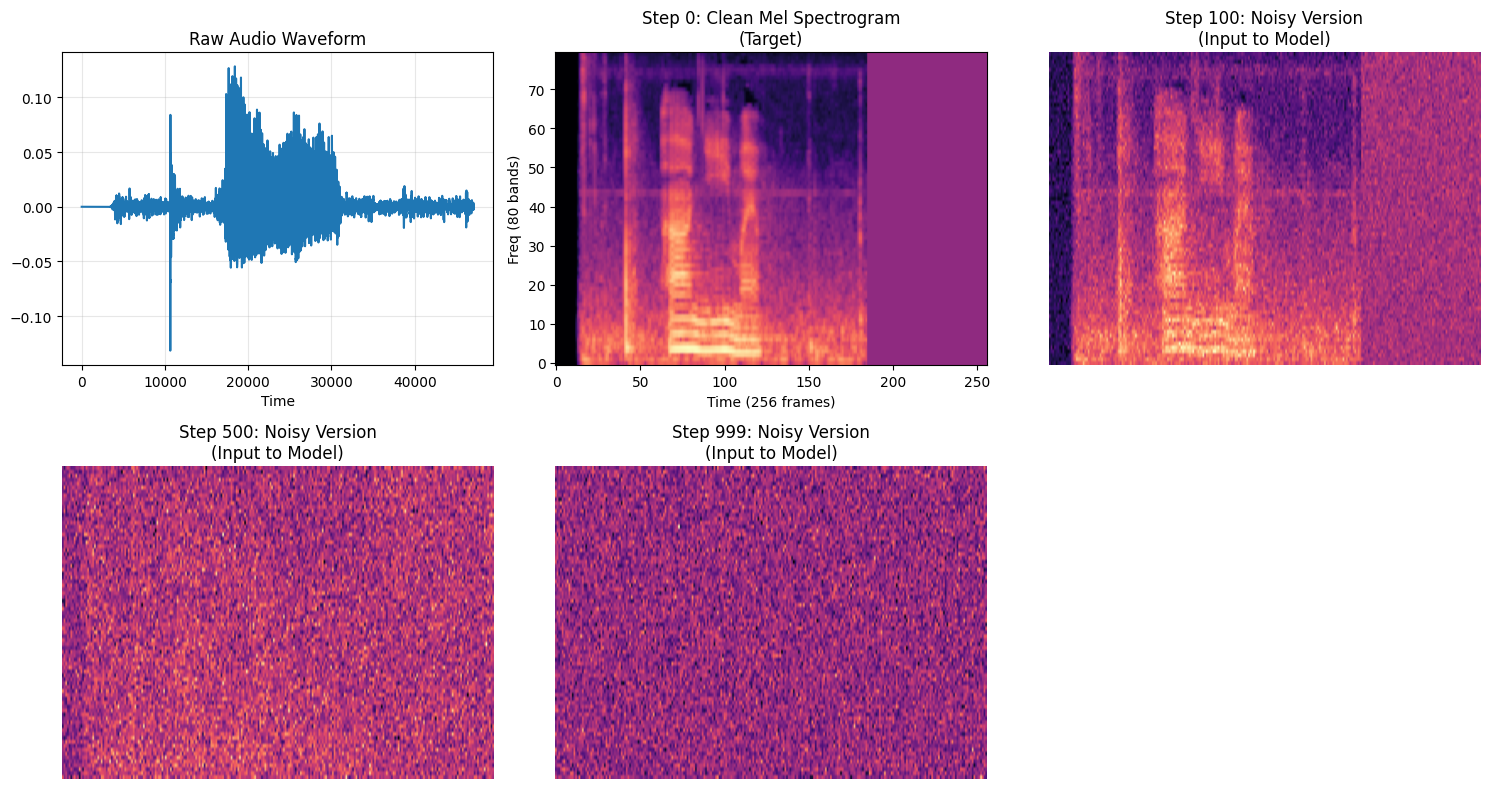

In [7]:
import torch
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import os

# ==========================================
# CONFIGURATION
# ==========================================
AUDIO_PATH = "assets/anime.wav"
SAMPLE_RATE = 16000
N_MELS = 80       # Height of the image
FRAMES = 256      # Width of the image (Time)

# ==========================================
# STEP 1: AUDIO TO MEL SPECTROGRAM
# ==========================================
print("--- STEP 1: LOADING & CONVERTING ---")

# 1. Load Audio
waveform, sr = torchaudio.load(AUDIO_PATH)
print(f"Original Waveform Shape: {waveform.shape} (Channels, Time)")

# 2. Resample (Crucial!)
# We must ensure sample rate is 22050, or the mel spec size will be wrong.
if sr != SAMPLE_RATE:
    resampler = T.Resample(sr, SAMPLE_RATE)
    waveform = resampler(waveform)

# 3. Mix to Mono (If stereo)
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)

# 4. Create Mel Spectrogram Transform
mel_transform = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,      # Window size for Fourier Transform
    hop_length=256,  # How much we move forward per pixel (Controls Width)
    n_mels=N_MELS,   # Controls Height
    normalized=True
)

# 5. Convert
mel_spec = mel_transform(waveform)

# 6. Log Scale (The "Loudness" fix)
# Raw mel values are exponential. We take Log to make them linear (Decibels).
mel_spec = torch.log(mel_spec + 1e-9)

# 7. Normalize (Make values roughly -1 to 1)
# This helps the Neural Network learn faster.
mel_mean, mel_std = mel_spec.mean(), mel_spec.std()
mel_spec = (mel_spec - mel_mean) / (mel_std + 1e-9)

print(f"Mel Spectrogram Shape: {mel_spec.shape}")
# Expect: [1, 80, Time]

# 8. Force Width to 256 (3 Seconds)
current_width = mel_spec.shape[-1]
if current_width < FRAMES:
    # Pad with zeros if too short
    padding = FRAMES - current_width
    mel_spec = torch.nn.functional.pad(mel_spec, (0, padding))
else:
    # Crop if too long
    mel_spec = mel_spec[..., :FRAMES]

print(f"Final Fixed Shape: {mel_spec.shape}")
# Expect: [1, 80, 256]

# ==========================================
# STEP 2: UNDERSTANDING TIMESTEPS & NOISE
# ==========================================
print("\n--- STEP 2: THE DIFFUSION PROCESS ---")

# Setup the "Schedule"
# This calculates: At step T, how much Signal vs How much Noise?
num_timesteps = 1000
betas = torch.linspace(0.0001, 0.02, num_timesteps) # How much noise added per step
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0) # Total signal remaining at step T

def get_noisy_image(x_start, t):
    """
    Mathematical Formula for Forward Diffusion:
    Noisy = sqrt(alpha_bar) * Clean_Image + sqrt(1 - alpha_bar) * Random_Noise
    """
    # 1. Create pure noise (Static)
    noise = torch.randn_like(x_start)
    
    # 2. Get the "mixing" values for this specific time t
    sqrt_alpha_bar = torch.sqrt(alphas_cumprod[t])
    sqrt_one_minus_alpha_bar = torch.sqrt(1.0 - alphas_cumprod[t])
    
    # 3. Mix them
    noisy_image = (sqrt_alpha_bar * x_start) + (sqrt_one_minus_alpha_bar * noise)
    
    return noisy_image, noise

# ==========================================
# STEP 3: VISUALIZATION
# ==========================================

# We will look at 4 moments in time
moments = [0, 250, 500, 999]

plt.figure(figsize=(15, 8))

# Plot 1: The Original Audio Waveform
plt.subplot(2, 3, 1)
plt.plot(waveform[0].numpy())
plt.title("Raw Audio Waveform")
plt.xlabel("Time")
plt.grid(True, alpha=0.3)

# Plot 2: The Clean Mel Spectrogram
plt.subplot(2, 3, 2)
plt.imshow(mel_spec[0].numpy(), origin='lower', aspect='auto', cmap='magma')
plt.title("Step 0: Clean Mel Spectrogram\n(Target)")
plt.xlabel("Time (256 frames)")
plt.ylabel("Freq (80 bands)")

# Plot 3-5: The Noising Process
for i, t in enumerate([100, 500, 999]):
    noisy_mel, _ = get_noisy_image(mel_spec, t)
    
    plt.subplot(2, 3, 3 + i)
    plt.imshow(noisy_mel[0].numpy(), origin='lower', aspect='auto', cmap='magma')
    plt.title(f"Step {t}: Noisy Version\n(Input to Model)")
    plt.xlabel("Time")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 1. Step
import torch
import torchaudio
import torchaudio.transforms as T
from torchvision import transforms
from PIL import Image
import math

# ==========================================
# CLASS 1: PREPARE THE CONDITION (IMAGE)
# ==========================================
class ImageConditioner:
    def __init__(self, img_size=512, patch_size=16):
        self.img_size = img_size
        self.patch_size = patch_size
        
        # Standard transformation: Resize -> Tensor -> Normalize to [-1, 1]
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) 
        ])

    def process(self, image_path):
        # 1. Load Image
        try:
            img = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {e}")
            return None

        # 2. Transform to Tensor [1, 3, 512, 512]
        x = self.transform(img).unsqueeze(0)

        # 3. Patchify Logic
        # We want to turn (Batch, 3, 512, 512) -> (Batch, 1024, 768)
        B, C, H, W = x.shape
        P = self.patch_size
        
        # Grid dimensions (e.g., 512 / 16 = 32)
        grid_h = H // P
        grid_w = W // P
        
        # Reshape to separate patches
        # Shape: (B, C, 32, 16, 32, 16)
        x = x.reshape(B, C, grid_h, P, grid_w, P)
        
        # Permute to group patches
        # Shape: (B, 32, 32, C, 16, 16)
        x = x.permute(0, 2, 4, 1, 3, 5)
        
        # Flatten
        # Shape: (B, 1024, 768)
        # 1024 = 32*32 patches
        # 768  = 3 channels * 16 * 16 pixels
        x = x.reshape(B, grid_h * grid_w, C * P * P)
        
        return x

# 1. Step
image_path = "assets/animeha.jpg"
conditioner = ImageConditioner()
conditioned_image = conditioner.process(image_path)
print(f"Conditioned Image Shape: {conditioned_image.shape}")


Conditioned Image Shape: torch.Size([1, 1024, 768])


In [ ]:

# ==========================================
# CLASS 2: PREPARE THE TARGET (NOISY MEL)
# ==========================================
class MelTargetNoiser:
    def __init__(self, sample_rate=22050, n_mels=80, frames=256, patch_size=4):
        self.sr = sample_rate
        self.n_mels = n_mels
        self.frames = frames
        self.patch_size = patch_size
        
        # Mel Spectrogram Transform
        self.mel_transform = T.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=256,
            n_mels=n_mels,
            normalized=True
        )
        
        # --- NOISE SCHEDULER SETUP (Simple Linear) ---
        # This defines how much noise to add at step t
        self.num_timesteps = 1000
        beta_start = 0.0001
        beta_end = 0.02
        
        # Calculate alphas (signal retention)
        betas = torch.linspace(beta_start, beta_end, self.num_timesteps)
        alphas = 1.0 - betas
        self.alphas_cumprod = torch.cumprod(alphas, dim=0) # Cumulative product

    def get_clean_mel(self, audio_path):
        # 1. Load Audio
        waveform, sr = torchaudio.load(audio_path)
        if waveform.shape[0] > 1: waveform = waveform.mean(dim=0, keepdim=True) # Mono
        if sr != self.sr: waveform = T.Resample(sr, self.sr)(waveform)
        
        # 2. Convert to Mel
        mel = self.mel_transform(waveform)
        mel = torch.log(mel + 1e-9) # Log scale
        
        # 3. Normalize roughly to [-1, 1]
        mel = (mel - mel.mean()) / (mel.std() + 1e-9)
        
        # 4. Fix Length (Pad or Cut to 256 frames)
        if mel.shape[-1] < self.frames:
            mel = torch.nn.functional.pad(mel, (0, self.frames - mel.shape[-1]))
        else:
            mel = mel[..., :self.frames]
            
        return mel.unsqueeze(0) # Add batch dim: [1, 1, 80, 256]

    def patchify(self, mel_tensor):
        # Turns [B, 1, 80, 256] -> [B, 1280, 16]
        B, C, H, W = mel_tensor.shape
        P = self.patch_size # 4
        
        # Grid: 80/4 = 20, 256/4 = 64
        # Reshape & Permute
        x = mel_tensor.reshape(B, C, H//P, P, W//P, P)
        x = x.permute(0, 2, 4, 1, 3, 5)
        # Flatten: 20*64 = 1280 patches, 1*4*4 = 16 values
        x = x.reshape(B, -1, C * P * P)
        return x

    def process(self, audio_path):
        """
        Returns:
            noisy_input: The patchified mel WITH noise (Input to DiT)
            timestep: The random step we picked (Input to DiT)
            noise: The pure noise we added (Target for Loss)
        """
        # 1. Get Clean Mel & Patchify
        clean_mel = self.get_clean_mel(audio_path) # [1, 1, 80, 256]
        clean_patches = self.patchify(clean_mel)   # [1, 1280, 16]
        
        # 2. Pick a Random Timestep (e.g., t=500)
        # We pick one time for the whole batch
        t = torch.randint(0, self.num_timesteps, (1,)).long()
        
        # 3. Create Noise
        noise = torch.randn_like(clean_patches)
        
        # 4. Add Noise (Forward Diffusion Formula)
        # noisy = sqrt(alpha_bar) * clean + sqrt(1 - alpha_bar) * noise
        
        sqrt_alpha_bar = torch.sqrt(self.alphas_cumprod[t])
        sqrt_one_minus_alpha_bar = torch.sqrt(1.0 - self.alphas_cumprod[t])
        
        noisy_patches = (sqrt_alpha_bar * clean_patches) + (sqrt_one_minus_alpha_bar * noise)
        
        return noisy_patches, t, noise

# ==========================================
# TEST RUN
# ==========================================
if __name__ == "__main__":
    # Setup paths
    img_path = "assets/animeha.jpg"
    audio_path = "assets/anime.wav"

    # 1. Prepare Image
    conditioner = ImageConditioner()
    img_vector = conditioner.process(img_path)
    print(f"\nCondition (Image) Shape: {img_vector.shape}")
    print("expected: [1, 1024, 768]")

    # 2. Prepare Target (With Noise)
    noiser = MelTargetNoiser()
    noisy_input, timestep, actual_noise = noiser.process(audio_path)
    
    print(f"\nNoisy Input (Mel) Shape: {noisy_input.shape}")
    print("expected: [1, 1280, 16]")
    print(f"Timestep Selected: {timestep.item()}")
    
    print("\n✅ Ready for Training Step:")
    print("model(hidden_states=noisy_input, encoder_hidden_states=img_vector, timestep=timestep)")
    print("loss = MSE(output, actual_noise)")

/home/vladimir_albrekht/projects/img_to_spec/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Original Image Size: (512, 512)
Simulated Latent Shape: torch.Size([1, 4, 64, 64])
DiT Input Shape: torch.Size([1, 1024, 16])
Original Size: 64x64
Patched Grid Size: 32x32
Running DiT Inference...
Raw Output Shape: torch.Size([1, 1024, 16])
Reconstructed Map Shape: torch.Size([1, 4, 64, 64])


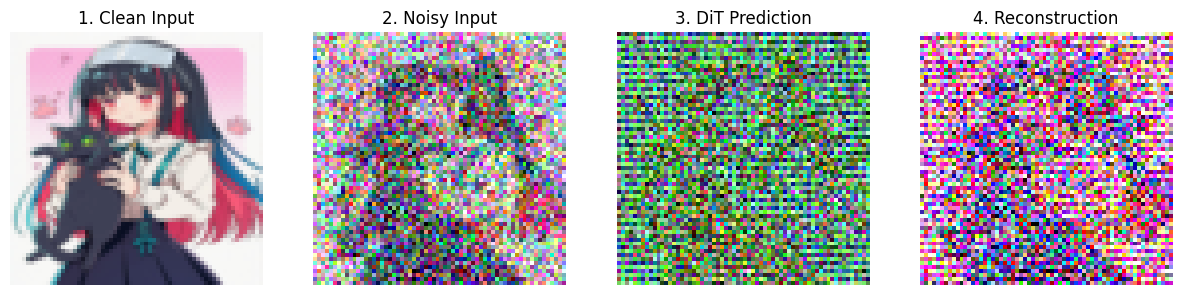

In [ ]:
import torch
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

height = 64
width = 64


config = {
    "patch_size": 2,          
    "in_channels": 16,        # 4 original * 2*2 patch area = 16
    "out_channels": 4,        # We want 4 back out (model expands this to 16 internally)
    "num_layers": 2,          
    "num_attention_heads": 4,
    "attention_head_dim": 32,
    "joint_attention_dim": 64,
    "axes_dims_rope": (4, 14, 14), 
    "guidance_embeds": False
}

# 1. Setup Paths
# We assume main_debug.ipynb is in /projects/img_to_spec/
sys.path.append(os.path.abspath("./diffusers/src")) 

from diffusers.models.transformers.transformer_qwenimage import QwenImageTransformer2DModel

# ==========================================
# PART 1: PREPARE THE REAL IMAGE ("Fake VAE")
# ==========================================

# Load your image
image_path = "assets/animeha.jpg"
if not os.path.exists(image_path):
    # Fallback if path is wrong, create a dummy image
    print(f"Warning: {image_path} not found. Creating a dummy red image.")
    pil_image = Image.new('RGB', (512, 512), color = 'red')
else:
    pil_image = Image.open(image_path).convert("RGB")

# Resize to 512x512 for display
pil_image = pil_image.resize((512, 512))

# --- SIMULATING THE VAE ---
# Real VAEs compress 512x512 images down to 64x64 Latents with 4 Channels.
# We will cheat and just resize the image to 64x64 to mimic a latent.
LATENT_SIZE = 64
IN_CHANNELS = 4 # VAEs usually have 4 channels (R, G, B, Alpha/Depth)

# Transform to tensor
transform = transforms.Compose([
    transforms.Resize((LATENT_SIZE, LATENT_SIZE)),
    transforms.ToTensor(), # converts to [0, 1]
    transforms.Normalize([0.5], [0.5]) # converts to [-1, 1]
])

# Shape: (3, 64, 64)
rgb_small = transform(pil_image)

# Add a 4th channel (dummy channel) to make it look like a real VAE latent
# Shape: (1, 4, 64, 64)
clean_latent = torch.cat([rgb_small, torch.zeros(1, LATENT_SIZE, LATENT_SIZE)], dim=0).unsqueeze(0)

print(f"Original Image Size: {pil_image.size}")
print(f"Simulated Latent Shape: {clean_latent.shape}")

# ==========================================
# PART 2: ADD NOISE (Diffusion Process)
# ==========================================

# Create random noise (Gaussian)
noise = torch.randn_like(clean_latent)

# Pick a timestep (how much noise?)
# Let's say we are halfway through generation (50% signal, 50% noise)
timestep = torch.tensor([500]) 

# Add noise to the clean latent
noisy_latent = 0.5 * clean_latent + 0.5 * noise

# ==========================================
# PART 3: PREPARE FOR DiT (FLATTEN)
# ==========================================

# The DiT doesn't take (Batch, Channels, Height, Width).
# It takes a sequence: (Batch, Seq_Len, Channels).
# We need to flatten the 64x64 grid into a line of 4096 tokens.

def patchify(x, p_size):
    """
    Splits image into patches and flattens them.
    Input: (Batch, Channels, Height, Width)
    Output: (Batch, Seq_Len, Channels * Patch^2)
    """
    batch, c, h, w = x.shape
    # Reshape to (Batch, C, H/P, P, W/P, P)
    x = x.reshape(batch, c, h // p_size, p_size, w // p_size, p_size)
    # Permute to (Batch, H/P, W/P, C, P, P) to group patches
    x = x.permute(0, 2, 4, 1, 3, 5)
    # Flatten: (Batch, Seq_Len, C * P * P)
    x = x.reshape(batch, (h // p_size) * (w // p_size), c * p_size * p_size)
    return x

# Patchify the noisy latent
# Input: (1, 4, 64, 64) -> Output: (1, 1024, 16)
# Note: 16 channels comes from 4 original channels * 2x2 patch area
hidden_states = patchify(noisy_latent, config["patch_size"])
print(f"DiT Input Shape: {hidden_states.shape}") # Should be (1, 4096, 4)

# ==========================================
# PART 4: THE BABY DiT
# ==========================================

# Initialize a tiny untrained DiT

model = QwenImageTransformer2DModel(**config)

# create dummy conditioning (The "Prompt")
encoder_hidden_states = torch.randn(1, 10, 64) # 10 words, 64 dim
encoder_hidden_states_mask = torch.ones(1, 10)
h_p = height // config["patch_size"]
w_p = width // config["patch_size"]

print(f"Original Size: {height}x{width}")
print(f"Patched Grid Size: {h_p}x{w_p}")
img_shapes = [[(1, h_p, w_p)]] # Tell RoPE the 2D shape

# ==========================================
# PART 5: INFERENCE
# ==========================================

print("Running DiT Inference...")
with torch.no_grad():
    output_obj = model(
        hidden_states=hidden_states,
        encoder_hidden_states=encoder_hidden_states,
        encoder_hidden_states_mask=encoder_hidden_states_mask,
        timestep=timestep,
        img_shapes=img_shapes,
        txt_seq_lens=[10]
    )

predicted_noise_seq = output_obj.sample 
# The output is (Batch, Seq_Len / Patch^2, Channels * Patch^2)
# Qwen DiT outputs "patched" data. We need to unpatchify it to see it as an image.

print(f"Raw Output Shape: {predicted_noise_seq.shape}")

# ==========================================
# PART 6: UNPATCHIFY & VISUALIZE
# ==========================================

def unpatchify(x, p_size, h, w, c):
    """
    Reverse the patching process to get back an image.
    x: (Batch, Seq_Len_Patched, Patch_Size*Patch_Size*Channels)
    """
    # Reshape back to grid of patches
    # (Batch, H/P, W/P, P*P*C)
    h_p = h // p_size
    w_p = w // p_size
    x = x.reshape(x.shape[0], h_p, w_p, p_size, p_size, c)
    # Permute to (Batch, H/P, P, W/P, P, C)
    x = x.permute(0, 1, 3, 2, 4, 5)
    # Reshape to (Batch, H, W, C)
    x = x.reshape(x.shape[0], h, w, c)
    # To (Batch, C, H, W)
    x = x.permute(0, 3, 1, 2)
    return x

# FIXED LINE: We simply pass '4' as the number of channels
predicted_noise_map = unpatchify(predicted_noise_seq, config["patch_size"], height, width, 4)

print(f"Reconstructed Map Shape: {predicted_noise_map.shape}")

# --- VISUALIZATION FUNCTION ---
def show_tensor(tensor, title):
    # Take first 3 channels (RGB), ignore 4th
    # Move to CPU, numpy, transpose to (H, W, C)
    img = tensor[0, :3, :, :].detach().cpu().permute(1, 2, 0).numpy()
    
    # Normalize for display (un-do the -1 to 1 scaling)
    img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(15, 5))

# 1. The Original Input (Simulated Latent)
plt.subplot(1, 4, 1)
show_tensor(clean_latent, "1. Clean Input")

# 2. The Noisy Input (What the DiT sees)
plt.subplot(1, 4, 2)
show_tensor(noisy_latent, "2. Noisy Input")

# 3. The DiT Output (What it predicted)
# NOTE: Since the model is UNTRAINED, this will look like random static!
plt.subplot(1, 4, 3)
show_tensor(predicted_noise_map, "3. DiT Prediction")

# 4. The Attempted Reconstruction
# Denoised = Noisy - Prediction
reconstruction = noisy_latent - predicted_noise_map
plt.subplot(1, 4, 4)
show_tensor(reconstruction, "4. Reconstruction")

plt.show()

--- STEP 1: RAW IMAGE ---
Shape: torch.Size([1, 3, 512, 512])

--- STEP 2: DEFINING THE GRID ---
Shape: torch.Size([1, 3, 32, 16, 32, 16])

--- STEP 3: GROUPING PIXELS ---
Shape: torch.Size([1, 32, 32, 3, 16, 16])

--- STEP 4: FLATTEN TO VECTORS ---
Final Shape: torch.Size([1, 1024, 768])

--- VISUAL PROOF ---


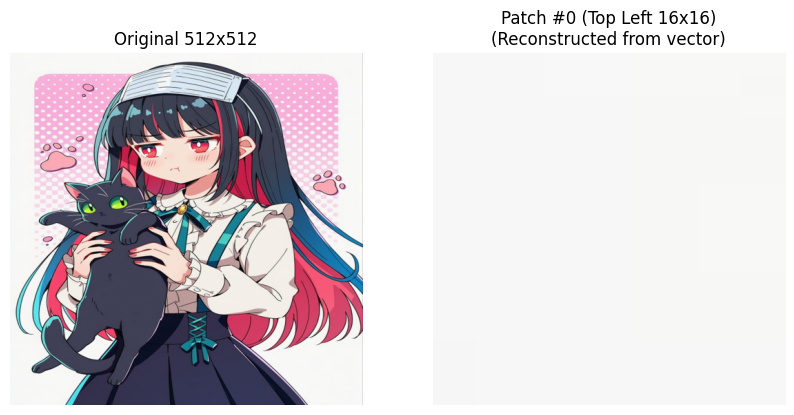

In [9]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Setup
image_path = "assets/animeha.jpg"
IMAGE_SIZE = 512
PATCH_SIZE = 16

# Create dummy image if file missing (for copy-paste safety)
if not os.path.exists(image_path):
    print("Image not found, creating dummy...")
    Image.new('RGB', (512, 512), color='blue').save(image_path)

# ==========================================
# STEP 1: LOAD & RESIZE
# ==========================================
print("--- STEP 1: RAW IMAGE ---")
# Load raw image
pil_image = Image.open(image_path).convert("RGB")
# Resize to ensure it is exactly 512x512
pil_image = pil_image.resize((IMAGE_SIZE, IMAGE_SIZE))

# Convert to Tensor (Numbers between -1 and 1)
to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
img_tensor = to_tensor(pil_image)

# Add Batch Dimension (1 image)
img_tensor = img_tensor.unsqueeze(0) 

print(f"Shape: {img_tensor.shape}") 
# Expect: [1, 3, 512, 512] -> (Batch, Channels, Height, Width)


# ==========================================
# STEP 2: THE "CUT" (RESHAPE)
# ==========================================
print("\n--- STEP 2: DEFINING THE GRID ---")
# We want to separate the dimensions into "Patches"
# 512 becomes (32 patches * 16 pixels)
# Shape becomes: (Batch, Channels, Grid_H, Patch_H, Grid_W, Patch_W)

batch, channels, height, width = img_tensor.shape
grid_h = height // PATCH_SIZE # 32
grid_w = width // PATCH_SIZE  # 32

step2_tensor = img_tensor.reshape(batch, channels, grid_h, PATCH_SIZE, grid_w, PATCH_SIZE)

print(f"Shape: {step2_tensor.shape}")
# Expect: [1, 3, 32, 16, 32, 16]


# ==========================================
# STEP 3: GROUPING PIXELS (PERMUTE)
# ==========================================
print("\n--- STEP 3: GROUPING PIXELS ---")
# We want to group the Grid IDs together and the Pixel IDs together.
# We move dimensions around so it looks like: (Batch, Grid_H, Grid_W, Channels, Patch_H, Patch_W)

step3_tensor = step2_tensor.permute(0, 2, 4, 1, 3, 5)

print(f"Shape: {step3_tensor.shape}")
# Expect: [1, 32, 32, 3, 16, 16]
# Note: The "3, 16, 16" are the actual pixels of one patch. 
# The "32, 32" is the position of the patch.


# ==========================================
# STEP 4: FLATTEN (THE FINAL VECTOR)
# ==========================================
print("\n--- STEP 4: FLATTEN TO VECTORS ---")
# 1. Flatten the Grid (32 * 32 = 1024 patches)
# 2. Flatten the Pixels (3 * 16 * 16 = 768 values)

final_vector = step3_tensor.reshape(batch, grid_h * grid_w, channels * PATCH_SIZE * PATCH_SIZE)

print(f"Final Shape: {final_vector.shape}")
# Expect: [1, 1024, 768]


# ==========================================
# VISUAL PROOF: RECONSTRUCT ONE PATCH
# ==========================================
print("\n--- VISUAL PROOF ---")
# Let's verify that the first vector [1, 0, :] actually contains image data.

# Take the first patch (Top-Left corner)
first_patch_vector = final_vector[0, 0, :] # Shape: [768]

# Un-flatten it back to visual shape [3, 16, 16]
patch_visual = first_patch_vector.reshape(3, 16, 16)

# Convert for plotting (Move channel to end, un-normalize)
patch_visual = patch_visual.permute(1, 2, 0).numpy()
patch_visual = (patch_visual * 0.5) + 0.5

plt.figure(figsize=(10, 5))

# Plot Original
plt.subplot(1, 2, 1)
plt.imshow(pil_image)
plt.title("Original 512x512")
plt.axis('off')

# Plot The Patch
plt.subplot(1, 2, 2)
plt.imshow(patch_visual)
plt.title("Patch #0 (Top Left 16x16)\n(Reconstructed from vector)")
plt.axis('off')

plt.show()

In [1]:
import torch
import sys
import os

# Assuming you are in diffusers/.jupyter, we need to go up to import src
sys.path.append(os.path.abspath("../diffusers/src"))

from diffusers.models.transformers.transformer_qwenimage import QwenImageTransformer2DModel



/home/vladimir_albrekht/projects/img_to_spec/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch.nn as nn
from dataclasses import dataclass


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


@dataclass
class Config:
    """All hyperparameters in one place"""
    
    # Image settings
    image_size: int = 512
    image_patch_size: int = 16  # 512/16 = 32x32 = 1024 patches
    image_channels: int = 3
    
    # Mel spectrogram settings
    mel_n_mels: int = 80           # Standard mel bins
    mel_n_fft: int = 1024
    mel_hop_length: int = 256
    mel_target_frames: int = 64   # Fixed length (≈3 seconds at 22kHz)
    mel_sample_rate: int = 22050
    mel_patch_size: int = 4        # Patch mel as 4x4 -> 20x64 = 1280 patches
    
    # DiT architecture
    hidden_size: int = 512         # Not too large for 4090s
    num_heads: int = 8
    num_layers: int = 8            # Moderate depth
    mlp_ratio: float = 4.0
    dropout: float = 0.1
    
    # Conditioning
    image_token_dim: int = 768     # 16*16*3 = 768 (raw patch pixels)
    cond_proj_dim: int = 512       # Project image tokens to this dim
    
    # Diffusion
    num_timesteps: int = 1000
    beta_start: float = 0.0001
    beta_end: float = 0.02
    
    # Training
    batch_size: int = 4
    learning_rate: float = 1e-4
    num_epochs: int = 100
    
    @property
    def num_image_patches(self) -> int:
        """Number of patches from image"""
        return (self.image_size // self.image_patch_size) ** 2  # 1024
    
    @property
    def num_mel_patches(self) -> int:
        """Number of patches from mel spectrogram"""
        h_patches = self.mel_n_mels // self.mel_patch_size      # 80/4 = 20
        w_patches = self.mel_target_frames // self.mel_patch_size  # 256/4 = 64
        return h_patches * w_patches  # 1280
    
    @property
    def mel_patch_dim(self) -> int:
        """Dimension of each mel patch"""
        return self.mel_patch_size * self.mel_patch_size  # 4*4 = 16

config = Config()


class MelProcessor:
    """Process audio to mel spectrograms and patchify for DiT"""
    
    def __init__(self, config: Config):
        self.config = config
        self.mel_transform = T.MelSpectrogram(
            sample_rate=config.mel_sample_rate,
            n_fft=config.mel_n_fft,
            hop_length=config.mel_hop_length,
            n_mels=config.mel_n_mels,
            normalized=True
        )
    
    def load_audio(self, path: str) -> Tuple[torch.Tensor, int]:
        """Load audio file and resample if needed"""
        waveform, sr = torchaudio.load(path)
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        
        # Resample if needed
        if sr != self.config.mel_sample_rate:
            resampler = T.Resample(sr, self.config.mel_sample_rate)
            waveform = resampler(waveform)
        
        return waveform, self.config.mel_sample_rate
    
    def to_mel(self, waveform: torch.Tensor) -> torch.Tensor:
        """
        Convert waveform to log-mel spectrogram.
        
        Input: (1, num_samples)
        Output: (1, n_mels, target_frames) = (1, 80, 256)
        """
        # Compute mel spectrogram
        mel = self.mel_transform(waveform)  # (1, 80, time)
        
        # Log scale
        mel = torch.log(mel + 1e-9)
        
        # Normalize to [-1, 1]
        mel = (mel - mel.mean()) / (mel.std() + 1e-9)
        mel = torch.clamp(mel, -3, 3) / 3  # Clip outliers, scale to [-1, 1]
        
        # Pad or truncate to fixed length
        target_len = self.config.mel_target_frames
        if mel.shape[-1] < target_len:
            mel = F.pad(mel, (0, target_len - mel.shape[-1]))
        else:
            mel = mel[..., :target_len]
        
        return mel  # (1, 80, 256)
    
    def patchify(self, mel: torch.Tensor) -> torch.Tensor:
        """
        Convert mel spectrogram to sequence of patches.
        
        Input: (B, 1, H, W) = (B, 1, 80, 256)
        Output: (B, num_patches, patch_dim) = (B, 1280, 16)
        
        Visual explanation:
        
        Mel (1, 80, 256):
        +--+--+--+--+...+--+
        |  |  |  |  |   |  |  <- 64 patches wide (256/4)
        +--+--+--+--+...+--+
        |  |  |  |  |   |  |
        ...                    <- 20 patches tall (80/4)
        +--+--+--+--+...+--+
        
        Each patch is 4x4 = 16 values
        Total: 20x64 = 1280 patches
        """
        if mel.dim() == 3:
            mel = mel.unsqueeze(0)  # (1, 1, 80, 256)
        
        B, C, H, W = mel.shape
        P = self.config.mel_patch_size
        
        # Reshape: (B, C, H/P, P, W/P, P)
        mel = mel.reshape(B, C, H // P, P, W // P, P)
        # Permute: (B, H/P, W/P, C, P, P)
        mel = mel.permute(0, 2, 4, 1, 3, 5)
        # Flatten: (B, num_patches, C*P*P)
        mel = mel.reshape(B, -1, C * P * P)
        
        return mel  # (B, 1280, 16)
    
    def unpatchify(self, patches: torch.Tensor) -> torch.Tensor:
        """
        Reverse patchification.
        
        Input: (B, 1280, 16)
        Output: (B, 1, 80, 256)
        """
        B = patches.shape[0]
        P = self.config.mel_patch_size
        H = self.config.mel_n_mels
        W = self.config.mel_target_frames
        H_P = H // P  # 20
        W_P = W // P  # 64
        
        # Reshape: (B, H/P, W/P, 1, P, P)
        x = patches.reshape(B, H_P, W_P, 1, P, P)
        # Permute: (B, 1, H/P, P, W/P, P)
        x = x.permute(0, 3, 1, 4, 2, 5)
        # Reshape: (B, 1, H, W)
        x = x.reshape(B, 1, H, W)
        
        return x
    
    def process(self, path: str) -> torch.Tensor:
        """Full pipeline: load -> mel -> patchify"""
        waveform, _ = self.load_audio(path)
        mel = self.to_mel(waveform)
        patches = self.patchify(mel)
        return patches.squeeze(0)  # (1280, 16)


class QwenDiTWrapper(nn.Module):
    """
    Wraps the QwenImageTransformer2DModel to work with our Image-to-Mel pipeline.
    
    Mapping:
    - Mel Spectrogram Patches -> hidden_states (The "Image" Qwen generates)
    - Image Pixels Patches    -> encoder_hidden_states (The "Text" Qwen reads)
    """
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        
        # 1. Configure Qwen
        # We use patch_size=1 because our data is ALREADY patched by MelProcessor.
        # This ensures Input Sequence Length == Output Sequence Length.
        self.qwen_config = {
            "patch_size": 1,              
            "in_channels": config.mel_patch_dim,   # 16 (Mel Patch Size 4x4)
            "out_channels": config.mel_patch_dim,  # 16
            "num_layers": 4,              # Keep it light for testing (Real Qwen is 60)
            "num_attention_heads": 8,
            "attention_head_dim": 64,
            "joint_attention_dim": config.image_token_dim, # 768 (Raw Image Pixels)
            "axes_dims_rope": (4, 14, 14),
            "guidance_embeds": False
        }
        
        print(f"Initializing Qwen DiT with config: {self.qwen_config}")
        self.transformer = QwenImageTransformer2DModel(**self.qwen_config)

    def forward(self, 
                noisy_mel: torch.Tensor,     # (B, 1280, 16)
                image_patches: torch.Tensor, # (B, 1024, 768)
                timesteps: torch.Tensor      # (B,)
               ) -> torch.Tensor:
        
        B = noisy_mel.shape[0]
        
        # 1. Create Masks for Image Conditioning
        # Qwen needs to know which "Text" (Image) tokens to attend to.
        # We attend to ALL image patches.
        seq_len_img = image_patches.shape[1]
        encoder_hidden_states_mask = torch.ones(B, seq_len_img).to(noisy_mel.device)
        txt_seq_lens = [seq_len_img] * B
        
        # 2. Calculate Geometry for RoPE
        # We need to tell Qwen the 2D shape of our Mel Spectrogram Grid.
        # Mel Specs are: 80 (Height) x 256 (Width)
        # We patched them by 4x4.
        # So Grid Size is: (80/4) x (256/4) = 20 x 64
        h_grid = self.config.mel_n_mels // self.config.mel_patch_size      # 20
        w_grid = self.config.mel_target_frames // self.config.mel_patch_size # 64
        
        # Shape format: List[List[Tuple(Time, Height, Width)]]
        # We use Time=1 because it's a single image/spec
        img_shapes = [[(1, h_grid, w_grid)] for _ in range(B)]
        
        # 3. Call Qwen
        # Note: Qwen outputs an object, we want .sample
        output = self.transformer(
            hidden_states=noisy_mel,
            encoder_hidden_states=image_patches,
            encoder_hidden_states_mask=encoder_hidden_states_mask,
            timestep=timesteps,
            img_shapes=img_shapes,
            txt_seq_lens=txt_seq_lens,
            return_dict=True
        )
        
        return output.sample # (B, 1280, 16)

    def count_parameters(self) -> int:
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

model = QwenDiTWrapper(config).to(DEVICE)

Initializing Qwen DiT with config: {'patch_size': 1, 'in_channels': 16, 'out_channels': 16, 'num_layers': 4, 'num_attention_heads': 8, 'attention_head_dim': 64, 'joint_attention_dim': 768, 'axes_dims_rope': (4, 14, 14), 'guidance_embeds': False}


In [8]:
model

QwenDiTWrapper(
  (transformer): QwenImageTransformer2DModel(
    (pos_embed): QwenEmbedRope()
    (time_text_embed): QwenTimestepProjEmbeddings(
      (time_proj): Timesteps()
      (timestep_embedder): TimestepEmbedding(
        (linear_1): Linear(in_features=256, out_features=512, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (txt_norm): RMSNorm()
    (img_in): Linear(in_features=16, out_features=512, bias=True)
    (txt_in): Linear(in_features=768, out_features=512, bias=True)
    (transformer_blocks): ModuleList(
      (0-3): 4 x QwenImageTransformerBlock(
        (img_mod): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=3072, bias=True)
        )
        (img_norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=False)
        (attn): Attention(
          (norm_q): RMSNorm()
          (norm_k): RMSNorm()
          (to_q): Linear(in_features=512, out_features=512,

In [3]:
model

QwenImageTransformer2DModel(
  (pos_embed): QwenEmbedRope()
  (time_text_embed): QwenTimestepProjEmbeddings(
    (time_proj): Timesteps()
    (timestep_embedder): TimestepEmbedding(
      (linear_1): Linear(in_features=256, out_features=128, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (txt_norm): RMSNorm()
  (img_in): Linear(in_features=4, out_features=128, bias=True)
  (txt_in): Linear(in_features=64, out_features=128, bias=True)
  (transformer_blocks): ModuleList(
    (0-1): 2 x QwenImageTransformerBlock(
      (img_mod): Sequential(
        (0): SiLU()
        (1): Linear(in_features=128, out_features=768, bias=True)
      )
      (img_norm1): LayerNorm((128,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (norm_q): RMSNorm()
        (norm_k): RMSNorm()
        (to_q): Linear(in_features=128, out_features=128, bias=True)
        (to_k): Linear(in_features=128, out_features=128, bias=True)
 

In [4]:
# --- 1. The "Noisy Audio Latent" ---
# Let's pretend we have a 16x16 latent image (small square)
# 16 * 16 = 256 tokens total.
# Batch size = 1
latent_height = 16
latent_width = 16
seq_len = latent_height * latent_width  # 256

# Shape: (Batch, Seq_Len, Channels)
hidden_states = torch.randn(1, seq_len, config["in_channels"]) 
print(f"Input Latent Shape: {hidden_states.shape}")


# --- 2. The "Fake QwenVL Condition" ---
# Let's pretend Qwen saw the image and gave us 10 tokens describing it
text_len = 10
# Shape: (Batch, Text_Len, Joint_Dim)
encoder_hidden_states = torch.randn(1, text_len, config["joint_attention_dim"])
# Mask (All 1s means pay attention to all text)
encoder_hidden_states_mask = torch.ones(1, text_len)


# --- 3. The Geometry (Crucial for Qwen DiT) ---
# This model uses Rotary Embeddings (RoPE). It needs to know the 2D grid shape.
# It expects a list of tuples: [(1, height, width)]
# Note: Since patch_size=2, the effective grid is smaller, but let's match the seq_len
img_shapes = [[(1, latent_height, latent_width)]] 


# --- 4. The Timestep ---
# "How much noise is there?" (Random step 500 out of 1000)
timestep = torch.tensor([500])

Input Latent Shape: torch.Size([1, 256, 4])


In [5]:
# Run the forward pass
output = model(
    hidden_states=hidden_states,
    encoder_hidden_states=encoder_hidden_states,
    encoder_hidden_states_mask=encoder_hidden_states_mask,
    timestep=timestep,
    img_shapes=img_shapes,
    txt_seq_lens=[text_len]
)

# Check the output
result = output.sample
print("-" * 30)
print(f"Output Shape: {result.shape}")
print("-" * 30)

# Verify Output matches typical DiT behavior
# We entered with (1, 256, 4) -> We usually want (1, 256, 4 * patch_size^2) or similar
# The definition of proj_out is: patch_size * patch_size * out_channels
# 2 * 2 * 4 = 16 channels output per token.

------------------------------
Output Shape: torch.Size([1, 256, 16])
------------------------------


/home/vladimir_albrekht/projects/img_to_spec/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Original Image Size: (512, 512)
Simulated Latent Shape: torch.Size([1, 4, 64, 64])
DiT Input Shape: torch.Size([1, 1024, 16])


NameError: name 'height' is not defined

In [1]:
print(5)

5


In [1]:
print(5)

5
